In [1]:
import rospy
import sensor_msgs.point_cloud2 as pc2

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from subprocess import Popen
import sys
sys.path.insert(0, "/home/ankit/rosbag/pyniel") # Pyniel as available on github
from numpy_tools.gridify import gridify
%matplotlib notebook
plt.ion()

global frames
frames = []
MAX_FRAMES = 1000

In [2]:
#!/usr/bin/env python
def callback(data):
    global frames
    rospy.loginfo("Frame: %s " +  rospy.get_caller_id() + "I heard %s", len(frames), data.width)
    clear_output(wait=True)
    frames.append(data)
    if len(frames) > MAX_FRAMES:
      rospy.signal_shutdown("Message received")
    
def listener():
    # In ROS, nodes are uniquely named. If two nodes with the same
    # node are launched, the previous one is kicked off. The
    # anonymous=True flag means that rospy will choose a unique
    # name for our 'listener' node so that multiple listeners can
    # run simultaneously.
    rospy.init_node('listener', anonymous=True)

    rospy.Subscriber("/velodyne_points", pc2.PointCloud2, callback)

    # spin() simply keeps python from exiting until this node is stopped
    rospy.spin()

if __name__ == '__main__':
#     pcore = Popen(['roscore'])
#     p = Popen(['rosbag','play','/home/ankit/rosbag/2018-03-06-14-03-06.bag']) # something long running
    listener()
#     p.terminate()
#     pcore.terminate()

[INFO] [1522593960.444983]: Frame: 349 /listener_18792_1522593918687I heard 20452


In [3]:
old_frames = frames

In [4]:
frames = old_frames
frames = [np.array([list(point) for point in pc2.read_points(frame, field_names = None)]) 
          for frame in frames]

In [6]:
# for i in range(len(frames)):
#     print len(frames[i])
print frames[0]
ind = 4
print max(frames[0][:,ind]), min(frames[0][:,ind])
print max(frames[0][:,3]), min(frames[0][:,3])

[[ -4.25411701e-01   7.47037053e-01  -2.30348960e-01   3.20000000e+01
    0.00000000e+00]
 [ -9.55616176e-01   1.67877495e+00   3.37180495e-02   1.90000000e+01
    8.00000000e+00]
 [ -6.22580409e-01   1.09416091e+00  -2.90636748e-01   5.00000000e+00
    1.00000000e+00]
 ..., 
 [ -2.50930858e+00   4.95253897e+00   1.28177118e+00   1.00000000e+01
    1.40000000e+01]
 [ -4.49936122e-01   8.88409555e-01  -1.73825976e-02   8.00000000e+00
    7.00000000e+00]
 [ -2.49544621e+00   4.92944574e+00   1.48044503e+00   1.50000000e+01
    1.50000000e+01]]
15.0 0.0
122.0 1.0


In [7]:
ind = 4
ring_id = 13
get_rings_0 = frames[0][:,ind]

def get_ring_i(ring_id, scan_id):
    get_rings = frames[scan_id][:,4]
    ring_0 = np.where(get_rings == ring_id)
#     print ring_0
    points_in_ring_0 = frames[scan_id][ring_0, :][0]
#     print points_in_ring_0[:,0:3]
#     print max(points_in_ring_0[:,0]), min(points_in_ring_0[:,0])

    x0 = points_in_ring_0[:,0]
    y0 = points_in_ring_0[:,1]
    z0 = points_in_ring_0[:,2]
    
    i0 = points_in_ring_0[:,3]
    
#     return x, y, z

#     x0, y0, z0 = get_ring_i(0, get_rings)
#     plt.figure()
#     plt.scatter(x0, y0, marker='s', edgecolor="none")


    w0 = np.arctan2(y0, x0)
    r0 = np.sqrt(x0*x0+y0*y0)
    r0_log = np.log10(r0+1)
    
    return x0, y0, z0, w0, r0_log, i0

In [8]:
print len(frames)

350


<IPython.core.display.Javascript object>


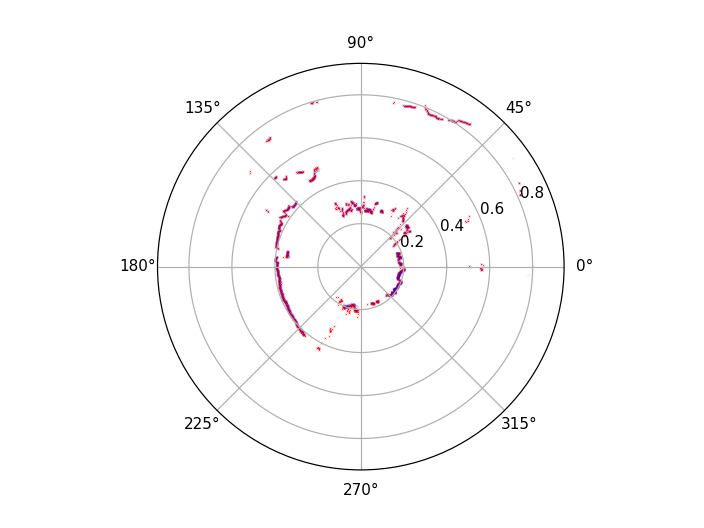

In [9]:
x0, y0, z0, w0, r0_log, i0 = get_ring_i(5, 0)
x1, y1, z1, w1, r1_log, i1 = get_ring_i(5, 298) #50


fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(w0, r0_log, cmap='hsv', alpha=0.75, s=0.05, marker='x', c='r')
c = ax.scatter(w1, r1_log, cmap='hsv', alpha=0.2, s=0.05, marker='o', c='b')


In [10]:
# # https://gist.github.com/temporaer/6755266
# def plot_logpolar(ax, theta, r_, bullseye=None, **kwargs):
#     min10 = np.log10(np.min(r_))
#     max10 = np.log10(np.max(r_))
#     if bullseye is None:
#         bullseye = min10 - np.log10(0.5 * np.min(r_))
#     r = np.log10(r_) - min10 + bullseye
#     ax.plot(theta, r, **kwargs)
#     l = np.arange(np.floor(min10), max10)
#     ax.set_rticks(l - min10 + bullseye) 
#     ax.set_yticklabels(["1e%d" % x for x in l])
#     ax.set_rlim(0, max10 - min10 + bullseye)
#     ax.set_title('log-polar manual')
#     return ax

# ax = plt.subplots(1, 2, subplot_kw=dict(polar=True))[1].flatten()
# plot_logpolar(ax[0], w0, r0_log)

In [11]:
# assuming 1600 points per ring, 360/1600 = 0.225 degrees
# divide log radius into 1200 parts
# divide ring into worst case horizontal angular resolution = 0.4 degrees
# divide log distance by 0.05
def occupancy(w, r_log):
    oc_grid = np.zeros((901, 200))
    angle_bin = np.rint(w*57.2958/0.4)+450
    distance_bin = np.rint(r_log/0.1)
    
    angle_bin = angle_bin.astype(int)
    distance_bin = distance_bin.astype(int)
#     print angle_bin
#     print distance_bin
    
#     print max(angle_bin), min(angle_bin)
#     print max(distance_bin), min(distance_bin)
    
    oc_grid[angle_bin, distance_bin] += 1
    return oc_grid

oc_grid = occupancy(w0, r0_log)
# print np.where(oc_grid == 1)

# plt.figure()
# plt.hist(np.where(oc_grid != 0)[1])

In [12]:
print "ere"
oc_grid_static = occupancy(w0, r0_log)
oc_grid_smoky = occupancy(w1, r1_log)

ere


In [13]:
def groundtruth_ring(static, smoky):
    gt = smoky - static
    r, c = np.where(gt < 1)
    gt[r, c] = 0
    return gt

def unpack_gt(gt, x_smoky, y_smoky, z_smoky, w_smoky, r_smoky, i_smoky):
    x_gt, y_gt, z_gt, w_gt, r_gt, label_gt, i_gt = [], [], [], [], [], [], []
    
    angle_bin = np.rint(w_smoky*57.2958/0.4) + 450
    distance_bin = np.rint(r_smoky/0.1)
    
    angle_bin = angle_bin.astype(int)
    distance_bin = distance_bin.astype(int)
    print angle_bin
    print distance_bin
    
    print len(angle_bin), len(distance_bin)
    
    r, c = np.where(gt == 1)
    print r, c
    
    for i in range(len(angle_bin)):
        if angle_bin[i] in r and distance_bin[i] in c:
            x_gt.append(x_smoky[i])
            y_gt.append(y_smoky[i])
            z_gt.append(z_smoky[i])
            w_gt.append(w_smoky[i])
            r_gt.append(r_smoky[i])
            label_gt.append(1)
            i_gt.append(i_smoky[i])
        else:
            x_gt.append(x_smoky[i])
            y_gt.append(y_smoky[i])
            z_gt.append(z_smoky[i])
            w_gt.append(w_smoky[i])
            r_gt.append(r_smoky[i])
            label_gt.append(0)
            i_gt.append(i_smoky[i])
    
    return x_gt, y_gt, z_gt, w_gt, r_gt, label_gt, i_gt
    

gt_grid = groundtruth_ring(oc_grid_static, oc_grid_smoky)
x_gt, y_gt, z_gt, w_gt, r_gt, label_gt, i_gt = unpack_gt(gt_grid, x1, y1, z1, w1, r1_log, i1)
print len(x_gt)
print len(y_gt)
print len(z_gt)
print len(w_gt)
print len(r_gt)
print len(label_gt)
print len(i_gt)

[368 367 367 ..., 361 361 360]
[2 2 2 ..., 2 2 2]
1398 1398
[182 443 471 494 504 529 539 539 565 568 718 733 787 871 880 882 883] [3 8 2 2 2 2 3 9 2 2 3 5 6 4 3 3 3]
1398
1398
1398
1398
1398
1398
1398


<IPython.core.display.Javascript object>


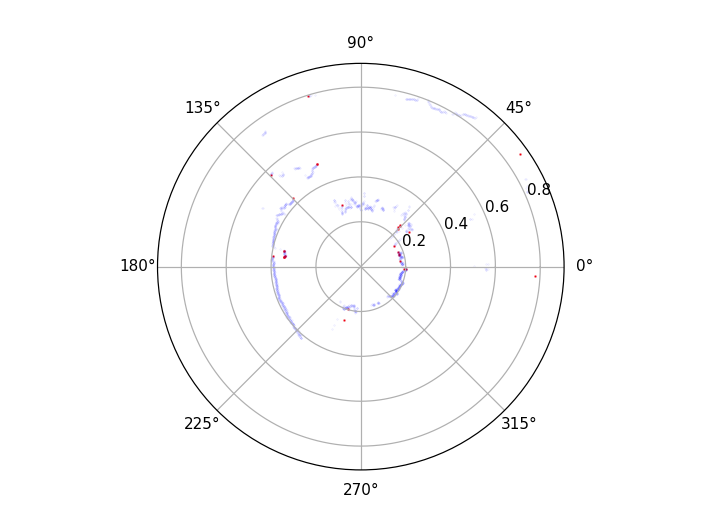

In [14]:
smoky_points = np.where(np.array(label_gt) == 1)[0]
# print smoky_points
w_gt = np.array(w_gt)
r_gt = np.array(r_gt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(w_gt[smoky_points], r_gt[smoky_points], cmap='hsv', alpha=1.0, s=0.2, marker='x', c='r')
c = ax.scatter(w1, r1_log, cmap='hsv', alpha=0.1, s=0.1, marker='o', c='b')

In [15]:
print max(r1_log)-min(r1_log), min(w0)
x = np.array(np.arange(10))
x = np.reshape(x, (2,5))
print x
print np.where(x >=16)

0.693197590975 -3.13949799528
[[0 1 2 3 4]
 [5 6 7 8 9]]
(array([], dtype=int64), array([], dtype=int64))


In [ ]:
def generate_files(frames, static_id, dataset_id, display_flag=False):
#     static_id = 0
#     dataset_id = 0
    # generate ground truth
    # x0, y0, z0, w0, r0_log = get_ring_i(13, 0)
    # x1, y1, z1, w1, r1_log = get_ring_i(13, 40) #50

#     print frames[0]
    ind = 4
    print max(frames[0][:,ind]), min(frames[0][:,ind])

    rings_present = [int(i) for i in np.unique(frames[0][:,ind])]
    print rings_present

    static_scene = {}
    for ring_id in rings_present:
        x0, y0, z0, w0, r0_log, i0 = get_ring_i(ring_id, static_id)
        static_scene[ring_id] = {"x0":x0, "y0":y0, "z0":z0, "w0":w0, "r0_log":r0_log, "i0":i0}

    # print static_scene[10].keys()

    for frame_id in range(len(frames)):
        # do I need to do this?
    #     if frame_id == static_id:
    #         continue

        dynamic_scene = {}
        for ring_id in rings_present:
            x1, y1, z1, w1, r1_log, i1 = get_ring_i(ring_id, frame_id)
            oc_grid_static = occupancy(static_scene[ring_id]["w0"], static_scene[ring_id]["r0_log"])
            oc_grid_smoky = occupancy(w1, r1_log)

            gt_grid = groundtruth_ring(oc_grid_static, oc_grid_smoky)
            x_gt, y_gt, z_gt, w_gt, r_gt, label_gt, i_gt = unpack_gt(gt_grid, x1, y1, z1, w1, r1_log, i1)
            dynamic_scene[ring_id] = {"x_gt":x_gt, "y_gt":y_gt, "z_gt":z_gt, \
                                      "w_gt":w_gt, "r_gt":r_gt, "label_gt":label_gt, "i_gt":i_gt}

            if display_flag == True:
                smoky_points = np.where(np.array(label_gt) == 1)[0]
                # print smoky_points
                w_gt = np.array(w_gt)
                r_gt = np.array(r_gt)
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='polar')
                c = ax.scatter(w_gt[smoky_points], r_gt[smoky_points], cmap='hsv', alpha=1.0, s=0.2, marker='x', c='r')
                c = ax.scatter(w1, r1_log, cmap='hsv', alpha=0.1, s=0.1, marker='o', c='b')

        np.savez_compressed(str(dataset_id) + "_" + str(frame_id), gt=dynamic_scene)


generate_files(frames, 0, dataset_id=3)

15.0 0.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[749 749 748 ..., 743 743 742]
[3 3 3 ..., 3 3 3]
1139 1139
[] []
[749 749 748 ..., 743 743 742]
[4 4 4 ..., 3 3 3]
1281 1281
[] []
[749 749 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1172 1172
[] []
[749 749 748 ..., 743 743 742]
[2 2 2 ..., 3 2 3]
1153 1153
[] []
[749 748 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1614 1614
[] []
[749 748 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1483 1483
[] []
[749 748 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1488 1488
[] []
[749 748 748 ..., 743 743 742]
[5 5 5 ..., 3 3 3]
1448 1448
[] []
[749 749 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1409 1409
[] []
[749 749 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1388 1388
[] []
[749 749 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1335 1335
[] []
[749 749 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1382 1382
[] []
[749 748 748 ..., 743 743 742]
[5 5 5 ..., 5 5 5]
1316 1316
[] []
[749 748 748 ..., 743 743 742]
[5 5 5 ..., 8 8 8]
1241 1241
[] []
[749 748 748

[728 727 727 ..., 722 721 721]
[3 3 3 ..., 3 3 3]
1148 1148
[ 22  65  66  68  69  80  90 109 110 305 514 549 564 590 658 680 777 793
 796 811 813 814 816 817 820 825 826 830 840 862 882 883] [3 3 2 2 2 3 3 2 3 2 3 4 2 2 3 3 2 3 2 2 3 2 2 3 3 3 3 3 3 3 3 3]
[728 727 727 ..., 722 721 721]
[2 2 2 ..., 2 2 2]
1285 1285
[  4  24  27  33  40  45  50  59  65  67  85  98 195 317 359 396 398 401
 405 409 503 542 563 568 659 694 697 752 753 766 823 832 854 857 861 863
 900] [3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 2 3 3 3 3 3 3 3]
[728 727 727 ..., 722 721 721]
[5 5 5 ..., 3 2 3]
1188 1188
[  1  14  18  37  44  45  52  63  98 107 108 111 114 120 168 228 257 281
 303 365 432 477 499 502 505 528 531 539 559 561 612 640 643 645 657 663
 701 703 716 718 722 723 774 775 778 798 800 801 802 808 814 815 821 824
 826 827 828 836 847 848 874 892] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 3 3 3 3 2 2 3
 3 3 2 2 3 2 2 2 3 2 2 2 2 3 3 3 4 4 4 4 4 3 3 3 3]
[727 727 727 ..

[713 713 712 ..., 708 707 707]
[3 3 3 ..., 3 3 3]
1137 1137
[ 37  39  68  71  72  76  81  82  90  91 104 110 136 393 548 568 590 592
 658 814 819 825 830 838 840 859 865 877] [3 3 3 2 2 2 3 2 3 3 2 3 3 2 4 3 2 2 3 2 3 3 3 3 3 3 3 3]
[713 713 712 ..., 708 707 707]
[2 2 2 ..., 2 2 2]
1270 1270
[  1   4  24  27  33  40  45  51  58  65  67  68  85  86  94 101 190 396
 398 401 420 476 498 503 592 694 695 696 697 745 746 753 766 798 820 823
 832 854 861 864 900] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 3 2 3 3 3 3 3 2 3 3 3 3
 3 3 3 3]
[713 713 712 ..., 708 707 707]
[2 2 2 ..., 2 2 2]
1176 1176
[  1  17  19  41  43  52  62  63  68  80 190 228 280 303 365 378 427 429
 430 432 499 502 528 531 536 539 559 663 701 704 722 723 773 778 799 801
 806 807 808 808 813 814 815 821 822 824 827 837 839 840 847 848 868 896] [3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 3 3 2 3 2 2 3 2 2
 2 2 4 4 3 3 3 4 4 4 3 3 3 3 3 3 3]
[713 713 712 ..., 708 707 707]
[3 3 3 ..., 3 3 3]
1162 1162
[ 1

 550 584 596 605 629 639 652 663 683 824] [5 6 2 2 2 2 2 2 2 2 6 8 2 2 2 2 2 2 3 8 3 8 8 2 3 2 3 4]
[699 699 698 ..., 694 693 693]
[3 3 8 ..., 3 3 3]
1413 1413
[115 129 259 284 319 342 343 344 479 490 560 561 569 574 631 637 665 671
 681 682 690 691 698 720 734 735 770 821 823] [5 5 2 2 2 2 2 2 2 2 4 2 2 3 8 8 8 8 7 8 3 2 3 3 5 5 6 5 4]
[699 699 698 ..., 694 693 693]
[8 8 8 ..., 8 8 8]
1403 1403
[ 72 106 138 141 143 206 212 226 230 262 263 268 273 278 333 343 442 443
 445 446 447 450 475 479 494 510 551 563 573 577 620 644 658 660 664 679
 692 695 728 806 810 820 870] [ 5  5  5  6  5  8 11  7  6  7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  9  9  3  3  8  3  3  8  3  3  8  8  3  4  4  4  5]
[699 699 698 ..., 694 693 693]
[8 8 8 ..., 8 8 8]
1330 1330
[ 72  74 185 195 197 209 214 218 220 223 223 270 273 275 334 344 454 560
 573 627 677 684 713 858] [ 4  4  5  6  6 11 11 11 11  6  9  2  2  2  2  2  2  9  2  8  8  7  3  6]
[699 699 698 ..., 694 693 693]
[8 8 8 ..., 8 8 8]
1391 1391


[685 685 684 ..., 680 679 679]
[3 3 3 ..., 8 8 3]
1414 1414
[ 73 106 138 139 141 143 188 212 214 217 218 220 222 226 228 229 230 262
 263 268 274 333 437 442 445 450 456 457 479 510 551 563 573 577 628 659
 660 679 680 692 693 695 700 709 806 807 810 820 856 863] [ 4  5  5  6  6  5  5  6 10  5 11  9  6  7  2  2  6  7  2  2  2  2  2  2  2
  2  2  2  2  2  9  9  3  3  8  3  8  3  8  8  3  8  8  3  4  4  4  4  4  7]
[685 685 684 ..., 680 679 679]
[8 8 7 ..., 3 3 3]
1335 1335
[ 72  74 171 185 192 209 210 214 217 223 223 270 273 280 281 321 334 344
 356 443 454 560 573 676 677 684 858] [ 4  4  6  5  6 11 11 11 11  6  9  2  2  2  2  5  2  2  6  2  2  9  2  8  7
  7  6]
[685 685 684 ..., 680 679 679]
[8 8 8 ..., 3 3 3]
1385 1385
[ 50  76 111 138 139 208 216 219 223 274 338 438 450 453 490 525 531 563
 583 589 675 677 683 713 731 762 772 870] [ 4  4  6  5  6  9 11 11  6  2  2  2  2  2  2 12  3  9  9  8  8  3  7  8 12
  8  5  5]
[685 684 684 ..., 679 679 678]
[8 7 8 ..., 7 7 7]
1318 1318
[ 52  

[671 671 670 ..., 666 665 665]
[8 8 8 ..., 8 8 8]
1419 1419
[ 73 106 139 141 143 188 212 214 217 218 220 222 226 228 229 230 262 263
 268 273 274 276 328 333 343 344 348 442 443 450 456 457 494 510 551 572
 600 628 679 680 695 697 722 729 766 806 807 810 820 863 864] [ 4  5  6  6  5  5  6 10  5 11  9  6  7  5  2  6  7  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  9  3  8  8  3  8  8  3  3 10  9  4  4  5  4  7
  5]
[671 671 670 ..., 667 666 666]
[8 8 8 ..., 8 8 8]
1327 1327
[ 72  73  74 110 171 179 192 195 209 210 214 217 223 225 270 273 280 321
 334 454 571 578 660 676 677 684 704 810] [ 4  5  4  6  6  5  6  6 11 11 11 11  9  7  2  2  2  5  2  2  3  2  8  8  7
  7  3  5]
[671 671 670 ..., 666 665 665]
[8 8 8 ..., 8 8 8]
1387 1387
[ 50  75  76 139 208 231 274 343 390 450 478 490 515 531 563 664 702 713
 762 772 870 875 893] [4 5 4 6 9 2 2 2 8 2 2 2 2 3 9 8 2 8 8 5 5 5 4]
[671 670 670 ..., 665 665 664]
[8 8 8 ..., 8 8 8]
1323 1323
[ 14  52 141 147 188 228 230 361 364 417 436 437 4

[ 73 106 138 141 143 212 214 217 218 220 222 226 227 228 229 230 230 231
 262 263 268 273 274 276 328 330 331 333 437 442 445 450 457 470 494 510
 567 577 584 628 660 679 680 692 693 695 697 806 807 810 820 863 864] [ 4  5  5  6  5  6 10  5 11  9  6  7  3  2  2  2  6  5  7  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  4  8  8  3  8  8  3  8  3  4  4  5
  4  7  5]
[656 656 653 ..., 652 651 651]
[8 8 8 ..., 8 8 8]
1331 1331
[ 72  73  74 143 171 179 192 195 209 210 214 217 223 270 273 274 279 280
 321 334 344 427 454 560 573 578 650 656 676 677 684 704 770 771 786 810
 857] [ 4  5  4  5  6  5  6  6 11 11 11 11  9  2  2  2  2  2  5  2  2  2  2  9  2
  2  3  8  8  7  7  3  6  5  5  5  6]
[657 657 656 ..., 652 651 651]
[8 8 8 ..., 8 8 8]
1385 1385
[ 50  75  76 139 208 231 232 278 338 343 347 349 450 453 478 490 515 563
 567 683 713 731 762 772 870 875 893] [ 4  5  4  6  9  2  2  2  2  2  2  2  2  2  2  2  2  9  2  7  8 12  8  5  5
  5  4]
[657 657 656 ..., 652 651 651]
[8 8 8 ..

[  9  10  13 115 139 181 212 213 230 259 342 344 451 490 560 574 637 637
 665 671 681 682 691 698 720 734 735 770 790 821 823] [4 4 5 5 6 5 6 7 5 2 2 2 2 2 4 3 3 8 8 8 7 8 2 3 3 5 5 6 5 5 4]
[643 643 642 ..., 638 637 637]
[8 8 8 ..., 8 8 8]
1410 1410
[ 72  73 138 139 141 143 206 208 212 217 218 220 222 226 229 230 262 263
 268 273 274 291 328 333 437 442 443 450 457 479 494 510 551 563 577 600
 628 644 659 660 664 679 692 693 695 728 806 810 820 856 870] [ 5  4  5  6  6  5  8  9 11  5 11  9  6  7  2  6  7  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  9  9  3  8  8  3  3  8  3  3  8  3  8  3  4  4  4  4
  5]
[643 643 642 ..., 638 637 637]
[8 8 8 ..., 8 8 8]
1344 1344
[ 72 192 197 209 210 214 217 223 223 270 273 275 280 321 334 356 454 560
 573 650 655 676 677 688 786 788 858] [ 4  6  6 11 11 11 11  6  9  2  2  2  2  5  2  6  2  9  2  3  8  8  7  7  5
  6  6]
[643 643 642 ..., 641 641 640]
[8 8 8 ..., 8 8 8]
1378 1378
[ 50  75  76 139 208 212 216 219 223 231 274 343 349 450 453 490 525 

[630 629 629 ..., 624 624 623]
[8 8 8 ..., 8 8 8]
1401 1401
[  9 129 138 259 284 331 344 490 560 561 569 573 574 631 637 646 664 665
 671 681 682 690 698 720 735 768 770 825] [4 5 6 2 2 2 2 2 4 2 2 9 3 8 8 3 2 8 8 7 3 3 3 3 5 6 6 5]
[630 629 629 ..., 628 628 627]
[8 8 8 ..., 3 3 3]
1401 1401
[ 73  74 107 139 141 226 229 258 260 263 268 273 275 328 333 348 443 450
 475 494 510 521 551 563 572 577 620 658 660 692 722 807 820 821 863 894] [4 4 5 6 6 7 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 8 9 9 3 3 8 3 8 2 3 4 4 5 7 4]
[627 626 626 ..., 624 624 623]
[8 8 8 ..., 8 8 8]
1332 1332
[146 179 192 209 270 273 280 290 321 334 454 555 560 568 571 572 573 576
 627 655 656 684 810] [ 6  5  6 11  2  2  2  2  5  2  2  9  9  3  3  3  2  2  8  8  8  7  5]
[629 629 629 ..., 624 624 623]
[8 8 8 ..., 8 8 8]
1387 1387
[ 75  76 139 231 251 274 338 343 348 450 490 515 563 589 683 684 713 762
 870] [ 5  4  6  2  9  2  2  2  2  2  2  2  9  8  7  7 10  8  5]
[629 629 628 ..., 624 624 623]
[8 8 8 ..., 8 8 8]
1325 1325
[ 

[592 592 592 ..., 613 612 612]
[2 2 2 ..., 3 3 3]
1122 1122
[ 21  22  37  68  69  81  87  90  91  93 110 115 136 305 393 548 549 568
 590 592 657 680 682 777 793 797 811 813 814 826 830 853 858 859 862 878
 883] [3 3 3 3 2 3 2 3 2 3 3 2 3 2 2 4 4 3 2 2 2 3 2 2 3 2 2 3 2 3 3 3 3 3 3 3 3]
[596 593 591 ..., 614 614 613]
[2 2 2 ..., 3 3 3]
1261 1261
[  3   4  24  40  45  50  57  58  59  65  67  73  86  94  98 101 188 231
 395 398 401 405 476 498 501 503 532 567 694 695 756 759 766 766 798 820
 832 861 863 864] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 2 3 2 4 4 2 3 3 3 3
 3 3 3]
[569 568 567 ..., 612 612 611]
[2 2 2 ..., 2 2 3]
1176 1176
[  1   9  19  41  43  44  45  52  60  61  63  81  99 104 108 110 121 134
 228 257 280 281 303 427 429 430 432 475 477 512 528 531 539 559 611 642
 657 665 701 704 776 798 800 801 806 807 808 814 815 818 822 824 826 827
 837 840 847 850 868 874] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 2
 2 3 3 2 3 2 2 2 2 2 3 3 

[ 75  76  77 139 222 343 348 450 478 490 515 563 567 664 762 772 870 893] [ 5  4  4  6 15  2  2  2  2  2  2  9  2  8  8  5  5  4]
[595 594 594 ..., 589 589 588]
[8 8 8 ..., 3 3 3]
1324 1324
[ 14  26  52  67 141 147 188 228 230 336 341 361 362 392 427 428 437 494
 543 551 560 568 684 770 812] [ 4  4  4  5  6  6  6  2  2  2 13  2  2 12 12 11  2  2  3  3  9  2  7 12  5]
[595 594 594 ..., 589 589 588]
[8 8 8 ..., 8 8 9]
1252 1252
[ 50  59 137 197 223 253 375 384 385 388 408 480 498 576 585 588 675 684
 745 767 823 856] [5 4 5 7 2 9 2 2 2 2 2 2 2 3 3 9 8 7 5 5 4 6]
[595 594 594 ..., 589 589 588]
[8 8 8 ..., 8 8 8]
1150 1150
[ 76  77  78 138 216 217 325 388 390 392 393 409 418 459 482 487 495 573
 579 675 676 677 704 727 731 806] [ 4  4  4  6  2  2  2  2  2  2  2  2 12  2  2  2  2  2  9  7  8  8 10 10 10
 10]
[595 594 594 ..., 589 589 588]
[8 8 8 ..., 8 8 8]
1255 1255
[ 57  59 112 148 154 164 198 206 255 456 464 480 489 490 531 548 675 676
 677 679 778] [5 4 5 5 6 5 6 2 9 2 3 2 2 2 2 3 8 7 7

[569 568 568 ..., 569 568 568]
[2 2 3 ..., 2 2 3]
1136 1136
[ 15  26  44  68  76  80  85  90 110 136 305 393 548 549 568 588 590 592
 658 680 762 793 811 814 817 830 835 858 859 882] [3 3 3 3 2 3 2 3 3 3 2 2 4 4 3 2 2 2 3 3 3 3 2 2 3 3 3 3 3 3]
[568 566 566 ..., 588 587 568]
[2 2 2 ..., 2 2 2]
1275 1275
[  0   3   4  24  27  33  40  50  51  58  59  67  73  86  94 375 398 401
 411 476 502 503 568 592 694 695 746 753 759 820 823 832 861 863 864] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 3 2 3 3 4 3 3 3 3 3 3]
[569 567 566 ..., 569 569 568]
[2 2 2 ..., 2 2 2]
1170 1170
[  1  37  40  42  43  52  60  63  81 103 107 110 114 168 190 228 258 280
 281 365 378 427 430 432 459 499 501 502 504 528 539 559 576 613 618 657
 663 701 716 722 723 775 802 807 814 816 818 821 822 824 827 837 839 840
 847 850 868 874 877] [3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 3 3 2 2
 3 3 2 3 2 2 3 3 4 3 3 4 4 3 3 3 3 3 3 3 3 3]
[574 573 573 ..., 568 568 567]
[3 3 3 ..., 3 2 2]
1156 115

 627 650 656 704 705 810 824] [ 4  4  5  6  7  2  2  2  2  2  2  2  2  9  9  3  2  9  8  3  8  3  2  5 11]
[560 559 559 ..., 554 554 553]
[9 9 9 ..., 9 9 9]
1386 1386
[ 74  75  76 139 148 232 264 274 450 478 490 515 589 677 683 713 731 762
 870 893] [ 4  5  4  6  6  2  2  2  2  2  2  2  8  3  7 10 12  8  5  4]
[558 558 557 ..., 554 554 553]
[9 9 9 ..., 9 9 9]
1320 1320
[ 77 131 141 144 147 228 265 342 352 360 361 362 428 437 520 559 560 568
 684 729 740] [ 4  6  6  5  6  2  2  2  2  2  2  2 11  2  2  9  9  2  7 11  5]
[560 559 559 ..., 554 554 553]
[9 9 9 ..., 9 9 9]
1242 1242
[ 50 222 253 375 384 385 386 394 488 489 498 571 576 588 675 677 767 780
 860] [5 2 9 2 2 2 2 2 2 2 2 2 3 9 8 8 5 6 6]
[559 559 558 ..., 554 554 553]
[9 9 9 ..., 9 9 9]
1157 1157
[ 77 203 218 221 246 249 318 385 390 392 418 482 487 499 573 579 675 676
 682 704 712 727 731 785] [ 4  2  2  2  2  2  2  2  2  2 12  2  2  2  2  9  7  8  7 10  8 10 10  9]
[560 559 559 ..., 554 554 553]
[9 9 9 ..., 9 9 9]
1264 1264
[ 57

[546 545 545 ..., 540 540 539]
[3 3 3 ..., 2 2 2]
1314 1314
[ 65  67  78 131 144 151 228 319 360 362 364 427 428 430 431 494 568 586
 684 729 770] [ 5  5  4  6  5  6  2  2  2  2  2 12 11  2 12  2  2  8  7 11 12]
[546 545 545 ..., 540 540 539]
[3 2 2 ..., 2 2 2]
1241 1241
[ 50 253 375 384 385 394 488 489 498 539 585 588 675 684 767 780 860] [5 9 2 2 2 2 2 2 2 2 9 9 8 7 5 6 6]
[546 545 545 ..., 544 543 543]
[3 3 3 ..., 3 3 3]
1149 1149
[ 76 138 139 218 388 390 392 393 409 418 482 487 492 548 573 579 675 676
 682 704 712 735 785] [ 4  6  6  2  2  2  2  2  2 12  2  2  2  2  2  9  7  8  7 10  8 10  9]
[546 545 545 ..., 540 540 539]
[ 9  9  9 ..., 12 12 12]
1259 1259
[ 79 112 198 206 207 208 244 246 463 464 487 495 531 544 675 677 679 736
 778 865] [4 5 6 2 2 2 2 2 3 3 2 2 2 3 8 7 7 9 9 5]
[539 539 538 ..., 534 533 533]
[2 2 2 ..., 2 2 2]
1147 1147
[ 22  26  38  40  66  69  72  76  84  90  93 110 136 196 306 379 549 568
 587 590 592 657 680 797 813 814 817 825 830 835 840 853 865 878 882] [3

[525 525 524 ..., 520 519 519]
[2 2 2 ..., 2 2 3]
1130 1130
[ 39  44  66  72  90 136 287 305 379 549 568 590 592 658 680 682 762 793
 811 825 826 830 853 858 859 865 882 883] [3 3 2 2 3 3 2 2 2 4 3 2 2 3 3 2 3 3 2 3 3 3 3 3 3 3 3 3]
[525 525 524 ..., 520 519 519]
[2 2 2 ..., 2 2 2]
1264 1264
[  0   1  27  33  51  58  67  70  71  73 101 316 395 398 401 501 503 532
 592 693 694 695 746 766 791 798 820 832 854 863 864] [3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 3 2 2 3 2 3 2 4 3 3 3 3 3 3]
[525 525 524 ..., 522 521 520]
[2 2 2 ..., 2 2 2]
1178 1178
[ 40  42  44  53  63  68  81 104 110 168 185 228 257 275 280 281 303 427
 430 432 459 475 499 501 512 536 539 559 657 663 701 716 722 723 801 802
 807 808 810 814 815 816 821 822 833 837 838 842 847 866 868 884 886 896
 899] [3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 3 3 2 3 2 2 2
 2 4 3 3 4 3 4 4 3 4 3 3 3 3 3 3 3 3]
[525 525 524 ..., 520 519 519]
[2 2 2 ..., 2 2 2]
1168 1168
[ 46  49 154 169 177 205 233 246 274 277 321 326 356 421 4

  2  3  3  9  2  2  3  8  8  7 11 12  5  4]
[511 511 510 ..., 506 505 505]
[2 2 2 ..., 2 2 2]
1237 1237
[  7 146 197 223 253 255 354 366 375 384 394 441 480 488 498 561 576 585
 587 684 708 712 767 796 856] [ 5  6  7  2  9  9 12 12  2  2  2  2  2  2  2  9  3  3  9  7 10 10  5  5  6]
[511 511 510 ..., 506 505 505]
[2 2 2 ..., 2 2 2]
1145 1145
[ 76 138 218 243 245 287 325 388 390 392 393 416 418 482 492 548 552 569
 573 578 582 586 675 676 677 682 712 726 733 785 796 806] [ 4  6  2  9  9  2  2  2  2  2  2 11 12  2  2  2  3  2  2  9  9  3  7  8  8
  7 10 10 10  9  5 10]
[511 511 510 ..., 506 505 505]
[2 2 2 ..., 2 2 2]
1256 1256
[ 62  79 112 148 154 164 198 206 208 219 326 479 480 489 496 531 543 545
 548 674 675 676 679 736 782 864] [ 5  4  5  5  6  5  6  2  2  2  2  2  2  2  2  2 12  3  3  7  8  7  7  9 10
  5]
[505 504 504 ..., 499 499 498]
[2 2 2 ..., 2 2 2]
1143 1143
[ 23  26  38  39  44  65  68  90  91 110 118 137 196 287 305 393 514 548
 568 590 592 657 658 680 777 811 813 814 816 

[497 497 497 ..., 495 494 493]
[2 2 2 ..., 2 2 2]
1306 1306
[ 65  78 130 144 146 206 228 266 272 335 352 361 364 417 427 428 430 431
 437 494 559 568 684 705 729 764 770 774] [ 5  4  8  5  6  9  2  2  6  2  2  2  2 12 12 11  2 12  2  2  9  2  7 10 11
  5 12  6]
[497 496 492 ..., 493 492 491]
[2 2 2 ..., 2 2 2]
1238 1238
[189 213 253 255 375 384 385 394 415 488 489 493 498 539 585 675 767 780
 796] [ 5  2  9  9  2  2  2  2 11  2  2  2  2  2  3  8  5  6  5]
[497 493 486 ..., 500 496 493]
[2 2 2 ..., 2 2 2]
1142 1142
[ 76 218 317 318 387 388 392 409 418 480 493 548 573 579 675 676 677 703
 704 712 768 785 796] [ 4  2  2  2  2  2  2  2 12  2  2  2  2  9  7  8  8 10 10  8  5  9  5]
[497 496 496 ..., 496 495 495]
[ 2  2 12 ..., 12 12 12]
1247 1247
[ 59  79 148 155 164 190 198 203 206 240 326 464 480 489 496 505 582 677
 736 778] [ 4  4  5  6  5  5  7  8  2 10  2  3  2  2  2 12  9  7  9  9]
[491 490 490 ..., 486 485 485]
[2 2 2 ..., 2 2 2]
1154 1154
[ 16  21  63  66  68  70  90  91  93 110 19

[477 477 476 ..., 472 472 471]
[2 2 2 ..., 2 2 2]
1154 1154
[ 21  39  66  68  69  72  81  90  91 104 110 136 305 393 514 548 588 590
 592 658 680 762 777 793 811 814 815 819 820 826 830 853 859 865 882 883
 896] [3 3 2 3 2 2 3 3 3 2 3 3 2 2 3 4 2 2 2 3 3 3 2 3 2 2 3 3 3 3 3 3 3 3 3 3 3]
[474 473 472 ..., 472 472 471]
[2 2 2 ..., 2 2 2]
1285 1285
[  0   3  24  40  45  50  58  65  67  71  73  94 101 188 190 394 409 501
 527 532 543 592 694 696 756 759 766 766 796 798 820 823 850 853 861 863
 864] [3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 3 2 2 3 3 4 4 2 3 3 3 3 3 3 3 3 3 3]
[473 473 472 ..., 472 472 471]
[2 2 2 ..., 2 2 2]
1178 1178
[  1   9  19  42  43  44  52  53  60  62  63  68  71  81 107 108 109 110
 114 168 190 228 257 281 303 348 378 460 499 501 531 536 538 539 559 576
 611 645 700 704 716 718 723 724 775 801 802 814 815 818 821 824 825 826
 827 832 835 836 840 840 847 850 886 887] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 3
 3 2 3 3 2 3 5 2 2 2 3 3 3 3

  4]
[420 419 419 ..., 478 478 477]
[2 2 2 ..., 2 2 2]
1232 1232
[ 50  75 197 253 374 375 384 385 388 394 420 488 493 498 539 576 585 675
 676 708 767 768 796] [ 5  5  7  9  2  2  2  2  2  2  2  2  2  2  2  3  8  8  8 10  5  5  5]
[464 463 461 ..., 463 460 460]
[2 2 2 ..., 2 2 2]
1133 1133
[ 76 203 215 218 250 287 325 392 416 418 459 482 487 499 548 573 579 581
 586 675 676 677 682 704 727 768 785 796 806] [ 4  2  2  2  2  2  2  2 11 12  2  2  2  2  2  2  9  9  3  7  8  8  7 10 10
  5  9  5 10]
[464 463 463 ..., 459 458 458]
[2 2 2 ..., 2 2 2]
1250 1250
[ 62  78  79 112 148 155 164 198 206 207 246 251 326 463 464 479 480 490
 582 657 674 676 677 736 757] [5 4 4 5 5 6 5 6 2 2 2 2 2 3 3 2 2 2 9 8 7 7 7 9 8]
[458 457 457 ..., 452 452 451]
[2 2 2 ..., 2 2 2]
1151 1151
[ 21  25  37  52  66  68  81  82  87  90  91 110 287 514 548 564 568 588
 590 592 680 762 777 811 813 814 815 820 828 830 835 840 853 858 859 878
 882] [3 3 3 3 2 3 3 2 2 3 3 3 2 3 4 2 3 2 2 2 3 3 2 2 3 2 3 3 3 3 3 3 3 3 3 3 

[444 444 443 ..., 440 439 439]
[2 2 2 ..., 2 2 2]
1138 1138
[ 15  20  21  22  37  39  68  69  73  80  84  86  90  91 110 136 196 305
 393 514 548 568 590 592 658 680 762 777 813 819 820 825 830 859 882] [3 2 3 3 3 3 3 2 2 3 3 2 3 3 3 3 2 2 2 3 4 3 2 2 3 3 3 2 3 3 3 3 3 3 3]
[444 444 443 ..., 439 439 438]
[2 2 2 ..., 2 2 2]
1285 1285
[  3  24  27  33  40  51  58  65  67  73  79  86  94 135 190 195 317 359
 375 379 398 401 476 506 527 543 694 695 697 760 761 766 798 820 823 832
 850 857 861 863 864 900] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 2 2 2 2 2 2 2 2 2 3 2 3 4 4 2 3 3 3 3 3
 3 3 3 3 3]
[444 444 443 ..., 439 439 438]
[2 2 2 ..., 2 2 2]
1192 1192
[  5   9  19  41  43  44  52  53  55  60  63  69  80 103 110 168 281 303
 318 365 378 427 430 432 460 477 499 501 527 531 536 539 559 611 612 642
 657 663 703 704 716 722 733 798 799 800 802 807 808 816 821 822 824 825
 826 827 835 839 847 850 874 895] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 3 3 3 2 2
 2 3 3 3 2 3 3 3 2

[432 431 431 ..., 427 426 426]
[2 2 2 ..., 2 2 2]
1183 1183
[ 21  44  63  64  67  68  69  80  85  90  95 100 110 136 393 514 549 564
 568 590 592 658 680 762 777 788 793 811 814 815 816 820 826 830 840 853
 858 859 862 865 865 874 876 877 877 878 878 880 882 882 883 883 885 886
 887 888 889 891 892 895] [3 3 3 3 2 3 2 3 2 3 3 2 3 3 2 3 4 2 3 2 2 3 3 3 2 2 3 2 2 3 2 3 3 3 3 3 3
 3 3 2 3 3 3 2 3 2 3 2 2 3 2 3 2 3 3 2 3 3 3 3]
[432 431 431 ..., 427 426 426]
[2 2 2 ..., 2 2 2]
1287 1287
[  3  24  40  50  58  59  65  67  85  86 101 359 395 396 398 420 502 527
 528 537 543 563 693 694 695 696 756 766 797 820 823 832 853 857 861 863
 864 900] [3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 3 2 2 2 3 2 3 4 2 3 3 3 3 3 3 3 3 3
 3]
[431 429 428 ..., 430 429 427]
[2 2 2 ..., 2 2 2]
1226 1226
[  1   7  19  38  42  55  63  95 104 107 110 111 114 228 232 257 280 281
 303 378 427 429 430 432 459 477 499 501 504 528 539 557 559 577 640 642
 645 657 701 703 704 716 722 774 775 798 802 807 808 814 815 816 821 82

 731 762 773 870 893] [ 4  5  4  6 15  2  2  2  2  2  2  2  8  3  7  7 10  8 12  5  6  5  4]
[425 424 424 ..., 420 420 419]
[12 12 12 ...,  2  2  2]
1315 1315
[ 52  67  76  78 131 141 144 147 188 230 342 361 392 428 437 494 559 568
 684 687 729 764 770 774 863] [ 4  5  4  4  6  6  5  6  6  2  2  2 12 11  2  2  9  2  7  7 11  5 12  6  4]
[419 418 418 ..., 478 476 419]
[ 2 12 12 ...,  2  2  2]
1234 1234
[ 50 145 197 222 225 253 375 384 386 394 413 489 498 539 576 585 588 675
 684 708 712 767 768 781 796] [ 5  6  7  2  2  9  2  2  2  2 13  2  2  2  3  8  9  8  7 10 10  5  5  6  5]
[418 409 405 ..., 463 460 460]
[12  2  2 ...,  2  2  2]
1132 1132
[ 76  77 218 317 387 388 392 409 418 482 499 548 573 579 675 676 682 703
 726 727 768 785 796 806] [ 4  4  2  2  2  2  2  2 12  2  2  2  2  9  7  8  7 10 10 10  5  9  5 10]
[383 368 325 ..., 458 458 457]
[12 12  2 ...,  2  2  2]
1248 1248
[ 62  75  78  79 112 148 154 164 190 198 207 208 255 480 487 489 531 582
 676 677 736] [5 5 4 4 5 5 6 5 5 6 2 

[412 412 411 ..., 407 407 406]
[2 2 2 ..., 2 2 2]
1319 1319
[ 39  65 112 130 144 202 224 272 360 361 362 364 364 417 438 551 559 561
 562 568 584 774] [ 4  5  5  8  5  8  2  6  2  2  2  2 12 12  2  3  9  9  2  2  3  6]
[407 406 406 ..., 412 407 406]
[ 2  2  2 ..., 13  2  2]
1234 1234
[145 197 218 222 223 253 255 354 366 374 375 384 394 412 420 569 576 585
 588 678 767 768 781 796] [ 6  7  2  2  2  9  9 12 12  2  2  2  2 13  2  3  3  3  9  8  5  5  6  5]
[405 404 404 ..., 419 418 409]
[ 2  2  2 ..., 12 12  2]
1145 1145
[ 76  77 245 287 317 325 388 393 409 418 494 499 578 579 582 586 675 677
 682 703 704 726 727 731 734 768 785 796] [ 4  4  9  2  2  2  2  2  2 12  2  2  9  9  9  3  7  8  7 10 10 10 10 10 10
  5  9  5]
[368 326 325 ..., 458 458 457]
[12  2  2 ...,  2  2  2]
1236 1236
[ 79 134 148 155 164 198 207 240 249 251 326 464 480 531 544 548 582 675
 677 736 757 778] [ 4  5  5  6  5  6  2 10 10  2  2  3  2  2  3  3  9  8  7  9  8  9]
[393 392 392 ..., 414 414 413]
[2 2 2 ..., 2 2 2]

1309 1309
[ 14  52  66  67 131 141 147 228 230 352 360 361 362 364 437 494 559 562
 568 684 729 770 774 863] [ 4  4  4  5  6  6  6  2  2  2  2  2  2  2  2  2  9  2  2  7 11 12  6  4]
[400 399 399 ..., 396 395 394]
[12  2  2 ...,  2  2  2]
1249 1249
[ 50  59 142 197 222 253 375 384 386 394 488 498 576 585 588 675 679 701
 708 767 768 781 796 856] [ 5  4  6  7  2  9  2  2  2  2  2  2  3  9  9  8  8 10 10  5  5  6  5  6]
[399 399 398 ..., 399 399 398]
[2 2 2 ..., 2 2 2]
1144 1144
[ 76 216 218 221 317 388 390 392 418 482 487 498 499 569 573 579 675 676
 682 683 704 734 751 768 785 796 806] [ 4  2  2  2  2  2  2  2 12  2  2  2  2  2  2  9  7  8  7  7 10 10  8  5  9
  5 10]
[383 368 325 ..., 458 458 457]
[12 12  2 ...,  2  2  2]
1246 1246
[ 62  75  79 112 148 154 164 198 208 255 464 489 531 544 582 657 675 677
 679 736 757 758] [5 5 4 5 5 6 5 6 2 9 3 2 2 3 9 8 8 7 7 9 8 8]
[393 392 392 ..., 389 388 388]
[2 2 2 ..., 2 2 2]
1174 1174
[  1  22  23  66  68  68  80  82  90  97 100 110 196 305 393

[387 386 386 ..., 382 382 381]
[2 2 2 ..., 2 2 2]
1311 1311
[ 14  26  52  65 131 144 147 227 266 272 360 361 362 427 428 431 559 562
 586 682 684 706 729 770 774] [ 4  4  4  5  6  5  6  2  2  6  2  2  2 12 11 12  9  2  8  8  7 10 11 12  6]
[384 383 383 ..., 383 382 381]
[2 2 2 ..., 2 2 2]
1234 1234
[ 46  50  59  76 213 223 317 375 384 385 394 420 489 494 498 539 565 585
 675 708 712 746 767 781 796 856] [ 4  5  4  5  2  2  2  2  2  2  2  2  2  2  2  2  2  8  8 10 10  8  5  6  5
  6]
[386 324 324 ..., 389 388 386]
[2 2 2 ..., 2 2 2]
1147 1147
[ 75  76  77 198 243 287 386 388 390 392 409 418 487 492 494 499 573 579
 583 586 675 676 677 731 751 768 769 785 796 806] [ 5  4  4  6  9  2  2  2  2  2  2 12  2  2  2  2  2  9  9  3  7  8  8 10  8
  5  5  9  5 10]
[368 368 326 ..., 458 458 383]
[12 12  2 ...,  2  2 12]
1239 1239
[ 57  59 112 148 190 206 209 240 243 244 249 326 480 544 582 674 676 736
 757 758 759] [ 5  4  5  5  5  2  2 10  2  2 10  2  2  3  9  7  7  9  8  8  8]
[381 380 380 ..., 

[375 374 374 ..., 370 369 369]
[2 2 2 ..., 2 2 2]
1339 1339
[ 74 143 145 197 214 218 222 223 223 270 273 279 280 332 334 356 427 454
 455 560 568 571 573 578 650 676 677 684 704 705 763 772 786 788 810 857
 860] [ 4  5  5  6 11 11  7  6  9  2  2  2  2  2  2  6  2  2  2  9  3  3  2  2  3
  8  8  7  3  2  5  6  5  6  5  6  6]
[375 374 374 ..., 370 369 369]
[2 2 2 ..., 2 2 2]
1385 1385
[ 74  76 139 148 216 219 223 231 274 338 343 349 438 450 478 490 531 563
 567 589 675 677 683 684 713 731 762 788 789 870 893] [ 4  4  6  6 11 11  6  2  2  2  2  2  2  2  2  2  3  9  2  8  8  3  7  7  8
 12  5  5  6  5  4]
[375 374 374 ..., 370 370 369]
[2 2 2 ..., 2 2 2]
1305 1305
[ 14  52  77 130 206 228 230 362 364 427 430 437 438 559 562 568 586 684
 721 729 770 774] [ 4  4  4  8  9  2  2  2 12 12  2  2  2  9  2  2  8  7 10 11 12  6]
[374 367 367 ..., 376 375 374]
[ 2 12 12 ...,  2  2  2]
1223 1223
[ 50 253 255 374 375 384 489 498 576 585 678 708 767 781 796 856] [ 5  9  9  2  2  2  2  2  3  8  8 10  5 

 789 870 875 893] [ 4  6  6 11  9  8 12  2  2  2  2  8  3  2  8 12  5  6  6  5  5  4]
[362 362 361 ..., 362 362 361]
[12  2  2 ..., 12 12  2]
1294 1294
[ 14  52  65 131 141 144 147 151 272 361 362 363 364 388 428 437 494 559
 586 683 684 687 729 770 774] [ 4  4  5  6  6  5  6  6  6  2  2  2  2 12 11  2  2  9  8  8  7  7 11 12  6]
[353 318 317 ..., 375 374 367]
[12  2  2 ...,  2  2 12]
1225 1225
[ 46  50  59  74 223 253 317 374 375 384 385 386 394 488 489 493 498 539
 576 585 588 589 675 679 708 767 781 796 856] [ 4  5  4  5  2  9  2  2  2  2  2  2  2  2  2  2  2  2  3  9  9  9  8  8 10
  5  6  5  6]
[324 324 323 ..., 389 388 388]
[2 2 2 ..., 2 2 2]
1130 1130
[138 217 243 287 318 388 390 392 393 418 459 482 487 492 499 548 573 579
 675 677 682 751 768 769 785 796 806] [ 6  2  9  2  2  2  2  2  2 12  2  2  2  2  2  2  2  9  7  8  7  8  5  5  9
  5 10]
[326 325 325 ..., 457 383 368]
[ 2  2  2 ...,  2 12 12]
1232 1232
[ 57  59  79 112 147 148 154 206 209 326 487 531 544 548 582 675 676 679

[254 253 248 ..., 367 353 353]
[ 9  9  9 ..., 12 12 12]
1221 1221
[  7  50  59  76 197 221 253 374 375 494 576 675 676 678 685 767 768 781
 796 856] [5 5 4 5 7 2 9 2 2 2 3 8 8 8 7 5 5 6 5 6]
[324 324 323 ..., 389 389 388]
[2 2 2 ..., 2 2 2]
1110 1110
[ 75  76 138 217 218 388 418 482 493 579 675 676 677 680 751 768 769 785
 796] [ 5  4  6  2  2  2 12  2  2  9  7  8  8  7  8  5  5  9  5]
[325 325 324 ..., 456 383 368]
[ 2  2  2 ...,  2 12 12]
1225 1225
[ 62  75  79 112 148 154 164 198 206 207 208 456 464 480 487 489 495 505
 676 736 757 758 759] [ 5  5  4  5  5  6  5  6  2  2  2  2  3  2  2  2  2 12  7  9  8  8  8]
[303 303 302 ..., 382 381 380]
[2 2 2 ..., 2 2 2]
1027 1027
[ 23  24  66  68  69  71  72  73  76  82  83  85  86  87  90 100 103 104
 137 393 548 568 594 628 678 680 761 777 778 854 860 861 863 866 867 868
 869 870 871 872 873 874 875 876 878 879 880 881 882 883 884 885 890] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2

[138 218 245 287 392 393 416 418 459 494 499 548 573 578 579 582 586 675
 676 680 682 751 768 769 785 796] [ 6  2  9  2  2  2 11 12  2  2  2  2  2  9  9  9  3  7  8  7  7  8  5  5  9
  5]
[326 325 325 ..., 457 368 367]
[ 2  2  2 ...,  2 12 12]
1213 1213
[ 59  79 148 155 164 198 240 249 251 326 367 463 531 675 677 679 680 681
 757 758 759 785 864] [ 4  4  5  6  5  6 10 10  2  2 12  3  2  8  7  7  7  7  8  8  8  9  5]
[305 303 303 ..., 381 380 380]
[2 2 2 ..., 2 2 2]
1124 1124
[ 23  66  68  69  70  71  72  73  80  82  87 104 107 108 110 115 305 393
 548 549 590 645 657 680 682 777 830 842 843 844 845 846 847 849 850 853
 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871
 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889
 890 891 891 892 893 894 894 895 895 896 896] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 2 3 2 3 2 3 2 3]
[331 330 330

[306 305 304 ..., 381 380 380]
[2 2 2 ..., 2 2 2]
1097 1097
[ 15  19  20  23  66  69  70  72  73  82  99 100 102 104 305 306 393 548
 564 588 680 777 814 824 830 831 838 840 844 848 852 853 854 855 856 860
 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878
 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[318 317 305 ..., 318 317 315]
[2 2 2 ..., 2 2 2]
1152 1152
[  3  33  50  59  94 134 190 317 375 398 405 477 506 543 586 694 741 759
 766 796 823] [3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 2 4 2 3 3]
[303 303 302 ..., 320 319 312]
[2 2 2 ..., 2 2 2]
1123 1123
[  1   5   8  15  19  43  52  63 107 109 114 168 281 303 429 460 502 505
 512 527 531 536 539 612 623 646 663 700 716 718 722 725 797 814 815 868
 871 876 877 878 884 885 886 887 888 889 890 893 895 899] [3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 3 2 2 

[272 272 271 ..., 336 335 335]
[2 2 2 ..., 2 2 2]
1304 1304
[ 73  74 214 218 222 223 232 270 427 454 573 576 578 663 676 677 701 705
 706 763 786 788 810] [ 5  4 11 11  8  9  2  2  2  2  2  2  2  2  8  8  2  2  2  5  5  6  5]
[273 273 272 ..., 339 338 338]
[2 2 2 ..., 2 2 2]
1355 1355
[ 75  76 139 140 148 216 219 223 231 338 450 453 490 515 525 531 567 571
 573 589 675 677 713 762 789 870 893] [ 5  4  6  6  6 11 11  6  2  2  2  2  2  2 12  3  2  2  2  8  8  3  8  8  6
  5  4]
[271 271 228 ..., 320 317 317]
[6 6 2 ..., 2 2 2]
1286 1286
[ 14  52  65  78 131 144 228 362 388 417 422 427 428 430 431 543 551 559
 568 584 586 684 729 741 764 765 766 770 774] [ 4  4  5  4  6  5  2  2 12 12  2 12 11  2 12  3  3  9  2  3  8  7 11  8  5
  5  5 12  6]
[255 254 253 ..., 367 353 318]
[ 9  9  9 ..., 12 12  2]
1218 1218
[ 50  59 142 223 253 255 375 384 394 415 488 489 493 498 580 585 679 746
 767 768 769 780 781 796] [ 5  4  6  2  9  9  2  2  2 11  2  2  2  2  9  3  8  8  5  5  5  6  6  5]
[288 288 28

[255 253 248 ..., 367 353 318]
[ 9  9  9 ..., 12 12  2]
1222 1222
[197 222 223 253 255 375 384 385 386 387 388 394 412 415 561 588 676 684
 746 767 768 769 781 796] [ 7  2  2  9  9  2  2  2  2  2  2  2 13 11  9  9  8  7  8  5  5  5  6  5]
[289 288 288 ..., 289 288 288]
[2 2 2 ..., 2 2 2]
1103 1103
[ 75 138 217 245 381 388 392 409 418 548 573 578 579 582 586 675 677 751
 768 785] [ 5  6  2  9  2  2  2  2 12  2  2  9  9  9  3  7  8  8  5  9]
[288 287 287 ..., 287 287 286]
[2 2 2 ..., 2 2 2]
1210 1210
[ 75  79 148 155 164 198 208 240 244 326 480 543 679 680 736 757 758 759
 760 761 762 763 778] [ 5  4  5  6  5  6  2 10  2  2  2 12  7  7  9  8  8  8  8  8  8  8  9]
[259 259 258 ..., 290 289 289]
[2 2 2 ..., 2 2 2]
1109 1109
[  0  45  65  66  67  68  69  70  71  72  73  77  82  83  88  89  90  94
 100 101 102 104 107 108 109 111 113 114 115 393 549 590 657 689 777 811
 814 836 837 840 841 842 846 847 848 849 851 852 853 854 855 856 857 859
 860 861 863 864 865 866 867 868 869 870 871 872 87

[255 253 248 ..., 367 367 353]
[ 9  9  9 ..., 12 12 12]
1210 1210
[ 50  58  79 139 189 197 253 255 375 384 385 394 416 494 498 571 580 585
 585 587 588 677 684 746 767 768 796 860] [ 5  5  4  5  5  7  9  9  2  2  2  2 11  2  2  2  9  3  8  9  9  8  7  8  5
  5  5  6]
[246 245 220 ..., 289 288 288]
[9 9 2 ..., 2 2 2]
1108 1108
[ 76 139 218 245 388 390 418 499 548 573 574 579 582 586 675 676 680 704
 727 751 768 785 796 802 806 807] [ 4  6  2  9  2  2 12  2  2  2  2  9  9  3  7  8  7 10 10  8  5  9  5  9 10
 10]
[256 251 250 ..., 288 287 287]
[9 9 2 ..., 2 2 2]
1211 1211
[ 59  79 155 164 198 206 207 240 249 496 545 546 657 675 676 677 757 758
 759 760 761 762 763 865] [ 4  4  6  5  6  2  2 10 10  2  3  3  8  8  7  7  8  8  8  8  8  8  8  5]
[259 259 258 ..., 289 289 288]
[2 2 2 ..., 2 2 2]
1047 1047
[ 23  24  66  67  68  69  72  73  77  82  83  85  86  87  88  98  99 100
 102 104 107 108 109 111 113 114 115 121 136 196 197 305 514 548 564 567
 590 592 657 761 864 867 868 869 870 871 872 

[248 248 247 ..., 367 367 353]
[ 9  9  9 ..., 12 12 12]
1212 1212
[ 50  59 140 145 197 374 375 384 385 386 387 388 394 412 488 571 588 675
 676 677 679 746 767 768 769 781 796] [ 5  4  6  6  7  2  2  2  2  2  2  2  2 13  2  2  9  8  8  8  8  8  5  5  5
  6  5]
[246 220 209 ..., 321 288 288]
[9 2 9 ..., 2 2 2]
1095 1095
[138 388 390 392 393 418 482 548 573 579 586 675 676 677 680 682 712 751
 768 785] [ 6  2  2  2  2 12  2  2  2  9  3  7  8  8  7  7  8  8  5  9]
[257 256 251 ..., 287 287 286]
[9 9 9 ..., 2 2 2]
1209 1209
[ 62  75  78  79 112 148 154 164 190 198 205 207 246 326 463 493 544 545
 675 676 677 736 757 758 759 760 761 762 763 864] [5 5 4 4 5 5 6 5 5 6 8 2 2 2 3 2 3 3 8 7 7 9 8 8 8 8 8 8 8 5]
[260 259 259 ..., 257 257 257]
[2 2 2 ..., 2 2 2]
1102 1102
[ 66  69  70  72  73  76  82  83  87  88  90 102 103 104 105 107 108 109
 110 111 113 114 196 306 393 588 592 645 678 680 682 761 777 825 830 841
 842 843 844 845 846 847 848 850 851 853 854 855 856 859 860 861 862 863
 864 865 8

 11  8  5  5  5  6  4]
[254 248 247 ..., 254 253 253]
[9 9 9 ..., 9 9 9]
1225 1225
[ 50 140 253 374 375 384 385 386 387 388 394 412 415 588 675 676 703 746
 767 768 781 796] [ 5  6  9  2  2  2  2  2  2  2  2 13 11  9  8  8 10  8  5  5  6  5]
[246 246 220 ..., 321 288 288]
[9 9 2 ..., 2 2 2]
1107 1107
[138 139 217 388 392 418 494 548 573 579 582 586 677 682 712 751 768] [ 6  6  2  2  2 12  2  2  2  9  9  3  8  7  8  8  5]
[251 251 250 ..., 251 251 250]
[2 9 2 ..., 9 9 2]
1219 1219
[ 62  81 112 190 198 204 205 206 208 251 326 543 657 676 736 757 758 759
 760 761 762 763] [ 5  4  5  5  6  7  8  2  2  2  2 12  8  7  9  8  8  8  8  8  8  8]
[250 250 249 ..., 246 245 245]
[2 2 2 ..., 2 2 2]
1114 1114
[ 38  65  66  68  69  70  71  72  81  82  83  87  90  99 100 101 104 107
 108 109 111 112 114 115 225 305 514 548 564 567 590 611 658 680 682 761
 777 814 829 841 847 848 850 852 853 855 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882

[238 238 237 ..., 234 233 233]
[2 2 2 ..., 2 2 2]
1084 1084
[ 23  24  66  68  69  70  72  73  76  77  82  85  87  90  98  99 100 102
 104 108 109 114 196 305 393 514 549 564 567 590 592 657 678 682 689 777
 836 846 848 849 853 854 859 860 861 863 867 868 869 870 871 872 873 874
 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892
 893 894 895 896] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[238 238 237 ..., 234 234 233]
[2 2 2 ..., 2 2 2]
1187 1187
[  3  24  27  33  40  45  50  58  65  67  73  86  94 135 190 199 317 396
 398 401 503 527 528 542 551 563 578 657 692 693 694 695 756 766 832 857
 863 864 900] [3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 4 2 3 3 3
 3 3]
[238 238 237 ..., 234 233 233]
[2 2 2 ..., 2 2 2]
1107 1107
[  1  18  42  43  45  55  58  63  65 107 108 168 303 378 427 430 432 528
 531 535 536 539 557 559 561 623 640 642

[226 194 194 ..., 228 227 227]
[2 2 2 ..., 2 2 2]
1089 1089
[ 23  66  67  69  70  72  73  76  77  82  83  85  88  89  94  99 100 103
 104 111 113 114 115 118 133 136 393 514 548 588 629 678 761 777 826 830
 843 848 857 858 859 860 861 862 863 864 865 866 867 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 883 884 885 886 887 888 889 890
 891] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 4 2 2 2 2 2 3 3 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2]
[196 196 195 ..., 233 233 231]
[2 2 2 ..., 2 2 2]
1182 1182
[ 24  27  33  45  58  65 101 134 190 193 231 375 395 398 401 405 408 420
 499 506 527 528 543 551 692 695 741 753 787 832 850 854 857 861 863 864
 900] [3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 3 3 3 3 3 3 3 3]
[199 199 198 ..., 228 227 226]
[2 2 2 ..., 2 2 2]
1150 1150
[  1  14  37  52  53  55  63  81 107 108 114 122 168 226 227 228 280 281
 427 429 432 528 531 535 536 539 559 623 624 640 642 657 663 665 718 719

[191 190 190 ..., 225 224 223]
[2 2 2 ..., 2 2 2]
1148 1148
[ 20  21  39  66  69  71  72  73  74  76  82  83  85  87  88  90  94  97
  98  99 100 104 107 109 111 223 224 225 305 393 514 548 564 567 590 592
 629 657 658 682 689 777 830 831 833 842 843 844 845 846 847 848 849 850
 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868
 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886
 887 888 889 890 891 892 893 894 895 896 897 898 899] [2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 2
 2 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[194 193 193 ..., 231 231 225]
[2 2 2 ..., 2 2 2]
1201 1201
[  1  24  27  40  50  58  59  65  67  68  73  94 101 188 190 193 225 231
 527 528 531 543 551 563 693 694 695 696 748 759 766 766 798 820 832 850
 854 857 861 864 873 880 882 883 885 886 890 891 900] [3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 

[207 207 206 ..., 202 201 201]
[9 8 8 ..., 7 7 7]
1206 1206
[ 50  59  76 203 213 225 253 255 354 375 384 489 561 585 588 702 746 767
 781 796 860] [ 5  4  5  7  2  2  9  9 12  2  2  2  9  3  9 10  8  5  6  5  6]
[207 206 202 ..., 202 201 201]
[8 8 7 ..., 7 7 7]
1105 1105
[ 75  76  77  78 198 245 388 416 418 482 548 573 579 582 586 675 676 677
 734 751 768 785 796 802] [ 5  4  4  4  6  9  2 11 12  2  2  2  9  9  3  7  8  8 10  8  5  9  5  9]
[205 204 204 ..., 202 201 201]
[2 8 2 ..., 7 7 7]
1223 1223
[ 59 112 148 157 190 209 240 249 251 326 367 479 545 577 677 757 758 778
 781 865] [ 4  5  5  6  5  2 10 10  2  2 12  2  3  9  7  8  8  9 10  5]
[194 193 193 ..., 195 195 194]
[2 2 2 ..., 2 2 2]
1108 1108
[ 19  39  63  65  66  68  71  80  81  87  90  93 110 196 197 393 514 549
 564 567 590 592 657 678 777 842 847 849 854 855 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 891 892 893 894 895] [2 3 3 3 2 2 2 3 3 2 

[187 187 186 ..., 182 181 181]
[2 2 2 ..., 2 2 2]
1069 1069
[ 23  66  69  70  72  76  77  83  88  89  90  99 100 101 103 104 107 108
 109 110 111 113 114 115 393 590 657 682 777 830 842 848 859 861 863 864
 865 866 867 869 870 871 872 873 874 875 876 877 877 878 879 880 882 883
 884 885 886 887 888 889 890 891 893 895] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[187 186 186 ..., 181 181 181]
[2 2 2 ..., 2 2 2]
1120 1120
[ 24 134 188 190 193 375 401 405 528 543 551 692 698 746 752 756 759 832
 850 857 861 864 873 900] [3 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 3 3 3 3 3 2 3]
[187 186 186 ..., 181 181 181]
[3 3 3 ..., 2 2 2]
1108 1108
[  1  10  14  44  62  63  68 110 168 190 227 228 257 281 430 528 531 535
 536 539 623 640 642 657 663 665 718 719 720 722 725 776 798 806 811 816
 821 865 866 867 868 871 872 873 874 876 877 878 884 885 886 887 888 889
 890 895] [3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 2

[173 172 172 ..., 167 167 166]
[5 5 5 ..., 5 5 5]
1351 1351
[ 74  75 139 146 149 222 349 450 490 567 589 677 702 762 870 893] [ 4  5  6  6  6 15  2  2  2  2  8  3  2  8  5  4]
[173 172 172 ..., 167 167 166]
[5 5 5 ..., 5 5 5]
1285 1285
[ 14  52  65  66  78 131 141 146 342 361 427 490 568 586 684 770 774] [ 4  4  5  4  4  6  6  6  2  2 12  2  2  8  7 12  6]
[173 172 172 ..., 167 167 166]
[5 5 5 ..., 5 5 5]
1221 1221
[ 46  50 197 224 253 375 384 385 388 420 498 675 676 678 684 746 767 781
 796 860] [4 5 7 2 9 2 2 2 2 2 2 8 8 8 7 8 5 6 5 6]
[173 172 172 ..., 167 167 166]
[5 5 5 ..., 5 5 5]
1116 1116
[ 75 392 418 499 548 573 579 675 677 680 768 785 796] [ 5  2 12  2  2  2  9  7  8  7  5  9  5]
[173 172 172 ..., 167 167 166]
[5 5 5 ..., 5 5 5]
1230 1230
[ 57 112 148 154 198 205 206 207 677 679 736 757 758 759 760 865] [ 5  5  5  6  6  8  2  2  7  7 10  8  8  8  8  5]
[166 166 165 ..., 161 160 160]
[2 2 2 ..., 2 2 2]
1123 1123
[  0   2  22  23  66  67  69  70  71  73  76  81  82  84  85  90 

  5  5  5  5  6]
[159 159 158 ..., 154 153 153]
[5 5 5 ..., 5 5 5]
1348 1348
[ 50  76 139 149 208 212 216 219 223 343 450 490 531 567 572 578 702 713
 762 870 875 893] [ 4  4  6  6  9 11 11 11  6  2  2  2  3  2  2  2  2  8  8  5  5  4]
[159 158 158 ..., 154 153 153]
[5 5 5 ..., 5 5 5]
1296 1296
[ 14  52  76  77 131 141 188 202 336 342 347 351 361 362 364 425 427 449
 491 551 559 561 562 568 584 729 770] [ 4  4  4  4  6  6  6  8  2  2  2  2  2  2  2  2 12  2  2  3  9  9  2  2  3
 11 12]
[159 158 158 ..., 154 153 153]
[5 5 5 ..., 5 5 5]
1237 1237
[ 46  50 137 197 253 255 374 375 384 385 386 387 388 420 423 489 561 585
 588 676 746 767 781 796 856] [4 5 5 7 9 9 2 2 2 2 2 2 2 2 2 2 9 3 9 8 8 5 6 5 6]
[159 158 158 ..., 154 153 153]
[5 5 5 ..., 5 5 5]
1109 1109
[ 75  76  77  78 138 245 386 388 418 552 573 578 582 675 677 768 785 806] [ 5  4  4  4  6  9  2  2 12  3  2  9  9  7  8  5  9 10]
[159 158 158 ..., 154 153 153]
[5 5 5 ..., 5 5 5]
1228 1228
[ 62  79 112 148 154 155 157 164 198 206 240

[145 144 144 ..., 140 140 139]
[5 6 6 ..., 5 5 6]
1229 1229
[ 50  59  74 189 197 213 221 253 255 375 385 394 408 420 423 489 561 585
 675 676 679 767 781 796 823] [5 4 5 5 7 2 2 9 9 2 2 2 2 2 2 2 9 3 8 8 8 5 6 5 4]
[145 145 144 ..., 140 140 139]
[5 5 5 ..., 5 5 5]
1108 1108
[ 75  76 138 218 250 287 418 499 548 552 573 578 582 586 675 676 677 680
 682 751 768 785 796 806] [ 5  4  6  2  2  2 12  2  2  3  2  9  9  3  7  8  8  7  7  8  5  9  5 10]
[145 145 144 ..., 140 140 139]
[5 5 5 ..., 5 5 5]
1224 1224
[ 57  59  79 112 155 164 198 240 249 251 326 367 546 577 676 679 757 758
 759 760 761 762 763] [ 5  4  4  5  6  5  7 10 10  2  2 12  3  9  7  7  8  8  8  8  8  8  8]
[139 139 138 ..., 134 133 133]
[2 2 2 ..., 2 3 3]
1025 1025
[ 23  24  66  67  69  70  73  76  77  83  85  87  88 100 103 107 108 109
 111 113 114 115 137 305 379 514 549 657 680 686 689 761 777 848 861 868
 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886
 887 888 889 890 892] [2 2 2 2 2 2 2 2 2 2 2 2 

 12]
[132 132 131 ..., 127 126 126]
[6 6 6 ..., 6 6 6]
1221 1221
[ 50  59  75  79 189 197 253 255 375 384 385 386 388 408 420 423 498 561
 571 577 580 585 588 676 679 746 767 781 796 856] [5 4 5 4 5 7 9 9 2 2 2 2 2 2 2 2 2 9 2 2 9 3 9 8 8 8 5 6 5 6]
[132 132 131 ..., 127 126 126]
[6 6 6 ..., 6 6 6]
1103 1103
[ 76  78 218 418 499 548 552 573 578 582 586 676 677 680 682 768 785 806] [ 4  4  2 12  2  2  3  2  9  9  3  8  8  7  7  5  9 10]
[132 132 131 ..., 127 126 126]
[8 8 8 ..., 6 6 6]
1219 1219
[ 62  79 112 148 155 164 198 206 240 251 367 489 496 543 675 676 677 679
 736 757 758 759 760 761 762 762 763] [ 5  4  5  5  6  5  7  2 10  2 12  2  2 12  8  7  7  7  9  8  8  8  8  8  8
  9  9]
[126 125 125 ..., 120 120 119]
[3 3 3 ..., 3 3 3]
1079 1079
[ 20  23  66  67  69  71  72  77  82  83  85  86  87  88  90  92  94  98
  99 100 102 104 107 114 115 225 514 549 590 629 645 688 761 777 842 853
 854 856 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 8

[119 118 118 ..., 113 113 112]
[6 6 6 ..., 6 6 6]
1209 1209
[ 50  59  60 197 253 255 375 394 420 498 561 588 675 676 767 780 796 823
 856] [5 4 4 7 9 9 2 2 2 2 9 9 8 8 5 6 5 4 6]
[119 118 118 ..., 113 113 112]
[6 6 6 ..., 6 6 6]
1098 1098
[ 76 218 245 418 499 548 552 573 579 582 675 676 677 680 768 785 806] [ 4  2  9 12  2  2  3  2  9  9  7  8  8  7  5  9 10]
[119 118 118 ..., 113 113 112]
[6 6 6 ..., 6 6 6]
1208 1208
[ 57 112 148 155 164 198 240 251 496 543 674 675 676 677 679 757 758 759
 760 761 762 762 763] [ 5  5  5  6  5  6 10  2  2 12  7  8  7  7  7  8  8  8  8  8  8  9  8]
[112 111 111 ..., 107 106 106]
[3 3 3 ..., 3 3 3]
1121 1121
[  0   1   2   3   4  23  24  66  68  69  70  72  73  82  83  85  86  87
  88 100 103 104 105 107 108 110 111 114 115 136 514 549 564 567 588 590
 628 657 658 680 777 836 843 845 846 847 848 849 850 851 852 853 854 855
 856 857 859 860 861 864 866 867 868 869 870 871 872 873 874 875 876 877
 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892

[105 105 104 ..., 100  99  99]
[5 5 5 ..., 5 5 5]
1215 1215
[ 58  59 374 375 384 385 386 387 394 498 589 675 676 678 746 767 781 860] [5 4 2 2 2 2 2 2 2 2 9 8 8 8 8 5 6 6]
[105 105 104 ..., 100  99  99]
[5 5 5 ..., 5 5 5]
1105 1105
[ 76  77 138 218 418 548 573 574 578 579 675 676 677 680 704 712 768 785] [ 4  4  6  2 12  2  2  2  2  9  7  8  8  7 10  8  5  9]
[105 105 104 ..., 100  99  99]
[5 5 5 ..., 5 5 5]
1231 1231
[ 59  75 112 148 157 164 198 198 206 326 489 546 675 677 679 736 757 758
 759 760 761 762 763 763 778 864] [4 5 5 5 6 5 6 7 2 2 2 3 8 7 7 9 8 8 8 8 8 8 8 9 9 5]
[ 98  98  94 ..., 100  99  98]
[3 3 2 ..., 2 2 2]
1002 1002
[  9  18  21  23  24  66  67  69  70  71  72  74  76  77  82  83  84  85
  87  88  94  98  99 100 103 104 107 108 112 113 114 115 196 305 514 549
 590 592 628 645 682 761 777 876 879 881 882 883 885 886 887 888 889 890
 891 893 895 896] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[

[91 91 90 ..., 86 85 85]
[4 4 4 ..., 4 4 4]
1441 1441
[ 94 100 106 133 175 328 333 336 551 566 568 582 599 619 652 676 716 717
 718 728 785 786 787 823 824 870 875 876 879 881] [5 5 4 5 2 2 2 2 9 2 2 3 8 8 2 2 2 2 8 5 6 6 6 5 5 4 4 4 3 3]
[91 91 90 ..., 86 85 85]
[5 5 5 ..., 5 5 5]
1395 1395
[131 140 183 208 377 382 581 610 639 649 662 663 683 732] [6 6 5 7 2 2 8 3 2 2 2 2 3 3]
[91 91 90 ..., 86 86 85]
[5 5 5 ..., 5 5 5]
1321 1321
[  9  10  14 129 235 344 560 562 574 631 662 664 665 681 682 691 692 726
 734 735 768 770 825] [4 4 5 5 5 2 4 2 3 8 3 2 8 7 3 2 2 2 5 5 6 6 5]
[91 91 90 ..., 86 85 85]
[5 5 5 ..., 5 5 5]
1326 1326
[138 214 226 346 456 561 577 620 660 663 679 688 692 807 820 824 863 894] [ 5 10  7  2  2  2  3  8  8  2  3  2  2  4  4  4  7  4]
[91 91 90 ..., 86 85 85]
[5 5 5 ..., 5 5 5]
1296 1296
[143 146 178 179 184 192 195 209 214 217 223 427 560 568 573 576 578 704
 705 706 786 787 810 824 858] [ 5  6  5  5  6  6  6 11 11 11  9  2  9  3  2  2  2  2  2  2  5  5  5  4  6]
[91 

[5 5 5 ..., 5 4 4]
1316 1316
[ 72  73  74 138 188 226 232 263 443 450 561 563 564 577 658 663 679 688
 692 703 820 863 894] [5 4 4 5 5 7 5 2 2 2 2 9 2 4 2 2 3 3 2 2 4 7 4]
[77 77 76 ..., 73 72 71]
[5 5 5 ..., 4 4 4]
1285 1285
[ 72  74 185 195 214 223 273 427 454 573 576 578 693 701 705 706 771 786
 787 810] [ 4  4  5  6 11  9  2  2  2  2  2  2  2  2  2  2  5  5  5  5]
[77 77 76 ..., 72 71 71]
[5 5 5 ..., 4 4 4]
1334 1334
[ 74  75  77 148 208 216 223 450 567 572 577 589 677 683 702 736 762 870
 893] [ 4  5  4  6  9 11  6  2  2  2  2  8  3  7  2  5  8  5  4]
[77 77 76 ..., 72 71 71]
[5 5 5 ..., 4 4 4]
1265 1265
[ 14  52  65  66  67  78 131 146 226 272 362 422 427 431 494 543 551 568
 586 684 740 774] [ 4  4  5  4  5  4  6  6  2  6  2  2 12 12  2  3  3  2  8  7  5  6]
[77 77 76 ..., 72 71 71]
[4 4 4 ..., 4 4 4]
1177 1177
[ 46  50  58 589 675 676 678 746 767 781 796 860] [4 5 5 9 8 8 8 8 5 6 5 6]
[77 77 76 ..., 72 71 71]
[5 5 5 ..., 4 4 4]
1094 1094
[ 76  77 138 418 548 573 579 582 675 677

[63 63 62 ..., 57 57 57]
[4 4 4 ..., 4 4 4]
1197 1197
[ 50  58  59 137 197 375 384 385 394 498 546 588 675 676 678 767 856] [5 5 4 5 7 2 2 2 2 2 2 9 8 8 8 5 6]
[63 63 62 ..., 57 57 57]
[4 4 4 ..., 4 4 4]
1091 1091
[ 76  77 418 548 573 579 582 586 675 676 677 768 806] [ 4  4 12  2  2  9  9  3  7  8  8  5 10]
[63 63 62 ..., 58 57 57]
[4 4 4 ..., 5 5 4]
1209 1209
[ 57  59  62  79 112 148 154 157 164 198 205 206 207 255 546 674 675 676
 677 736 757 758 759 760 761 762 763 778] [5 4 5 4 5 5 6 6 5 6 8 2 2 9 3 7 8 7 7 9 8 8 8 8 8 8 8 9]
[24 23 23 ..., 67 66 66]
[2 2 2 ..., 3 2 2]
1092 1092
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  20  22  23
  24  66  68  69  70  71  72  73  76  77  82  83  85  87  88  89  91  93
  94  99 100 102 103 104 105 107 108 109 111 112 114 115 136 196 197 514
 549 564 567 592 645 657 678 680 761 777 854 856 860 870 871 874 875 876
 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894
 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 

[ 79 213 375 385 388 676 679 767 856] [4 2 2 2 2 8 8 5 6]
[49 48 48 ..., 43 42 42]
[4 4 4 ..., 4 4 4]
1100 1100
[ 76  78 138 198 218 317 418 548 573 579 582 675 676 680 727 768 785 806] [ 4  4  6  6  2  2 12  2  2  9  9  7  8  7 10  5  9 10]
[49 48 48 ..., 43 42 42]
[4 4 4 ..., 4 4 4]
1213 1213
[ 59  75 148 155 164 198 207 209 675 676 677 679 757 758 759 760 761 762
 763 778] [4 5 5 6 5 6 2 2 8 7 7 7 8 8 8 8 8 8 8 9]
[ 23 896 894 894 893 889 889 885 884 881 881 879 790 784 783 780 780 779
 777 777 776 776 775 775 774 773 773 772 771 771 770 770 769 769 768 768
 767 767 766 766 765 764 764 763 762 762 761 761 760 760 759 759 758 758
 757 757 756 756 755 755 754 754 753 753 752 752 751 751 750 750 749 749
 748 748 747 747 746 746 745 745 744 744 743 743 742 742 741 741 740 740
 739 739 738 738 737 737 736 736 735 735 734 734 733 733 732 732 731 731
 730 730 729 729 728 728 727 727 726 726 725 725 724 724 723 723 722 722
 721 721 720 720 720 719 719 718 718 717 717 716 716 715 715 714 714

[41 41 40 ..., 36 35 35]
[4 4 4 ..., 4 4 4]
1186 1186
[ 50 197 224 253 375 546 561 676 679 746 767 856] [5 7 2 9 2 2 9 8 8 8 5 6]
[41 41 40 ..., 36 35 35]
[4 4 4 ..., 4 4 4]
1091 1091
[138 325 418 548 552 573 578 579 582 586 676 682 768] [ 6  2 12  2  3  2  9  9  9  3  8  7  5]
[41 41 40 ..., 36 35 35]
[4 4 4 ..., 4 4 4]
1192 1192
[ 57  75 112 148 154 157 198 206 255 543 577 676 677 736 757 758 759 760
 761 762 763] [ 5  5  5  5  6  6  6  2  9 12  9  7  7  9  8  8  8  8  8  8  8]
[ 24  23  23  20 895 893 893 892 892 891 891 890 890 889 889 888 888 887
 887 886 886 885 884 884 883 883 882 882 881 881 880 880 879 879 878 878
 873 871 868 860 848 846 844 824 784 783 779 779 778 777 776 775 775 774
 774 773 773 772 771 771 770 770 769 768 768 767 767 766 766 765 765 764
 764 763 762 761 761 760 760 759 759 758 758 757 757 756 756 755 755 754
 754 753 753 752 752 751 751 750 750 749 749 748 748 747 747 746 746 745
 745 744 744 743 743 742 742 741 741 740 740 739 739 738 738 737 737 737
 736

[34 34 33 ..., 28 28 27]
[4 4 4 ..., 4 4 4]
1409 1409
[133 138 183 187 196 377 382 438 439 441 446 556 639 649 652 724 732 819] [6 6 5 6 2 2 2 2 5 5 8 9 2 2 3 2 3 5]
[34 34 33 ..., 28 28 27]
[4 4 4 ..., 4 4 4]
1331 1331
[  9  13  74  76 139 181 210 228 230 235 560 569 574 633 645 664 681 682
 691 692 698 726 734 735 768 770 822] [4 5 5 4 6 5 8 5 5 5 4 2 3 3 2 2 7 8 2 2 3 2 5 5 6 6 4]
[34 33 33 ..., 28 28 27]
[4 4 4 ..., 4 4 4]
1336 1336
[106 138 141 214 218 220 258 262 263 268 333 494 551 572 577 620 628 660
 679 688 692 692 693 695 704 820 856 863 894] [ 5  5  6 10 11  9  2  7  2  2  2  2  9  3  3  8  8  8  3  3  2  8  2  8  2
  4  4  7  4]
[34 33 33 ..., 28 28 27]
[4 4 4 ..., 4 4 4]
1305 1305
[ 74 178 179 192 195 209 210 214 217 223 225 261 270 321 334 344 427 454
 573 576 578 676 677 688 705 706 713 719 786 787] [ 4  5  5  6  6 11 11 11 11  9  7  2  2  5  2  2  2  2  2  2  2  8  8  7  2
  2  3  8  5  5]
[34 34 33 ..., 28 28 27]
[4 4 4 ..., 4 4 4]
1339 1339
[ 74 139 149 208 343 450 5

[19 19 18 ..., 13 13 12]
[4 4 4 ..., 4 4 4]
1218 1218
[ 50  58  59  79 189 202 253 374 375 384 385 386 394 488 498 561 588 676
 677 678 679 746 767 780] [5 5 4 4 5 8 9 2 2 2 2 2 2 2 2 9 9 8 8 8 8 8 5 6]
[19 19 18 ..., 13 12 12]
[4 4 4 ..., 4 4 4]
1105 1105
[ 76 138 388 390 392 418 548 573 579 582 586 675 676 677 682 768] [ 4  6  2  2  2 12  2  2  9  9  3  7  8  8  7  5]
[19 19 18 ..., 13 12 12]
[4 4 4 ..., 4 4 4]
1200 1200
[ 62  79 148 155 164 198 199 240 489 546 674 676 677 679 736 757 758 759
 760 761 762 763 864] [ 5  4  5  6  5  7  2 10  2  3  7  7  7  7  9  8  8  8  8  8  8  8  5]
[  2 899 898 ...,  23   7   6]
[2 2 2 ..., 2 2 2]
1043 1043
[  2   6   7  23  66  67  76  77  82  90 101 104 105 107 108 111 112 114
 115 116 196 197 198 393 514 549 590 680 777 820 830 844 860 866 870 872
 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890
 891 892 893 894 895 896 897 898 899] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 3 2 3 3 2 2 2 2 2 2
 2 2 2 2 2 2 2 

[896 896 894 ..., 890 889 889]
[2 2 2 ..., 2 2 2]
1002 1002
[  4   5  20  23  24  65  66  69  76  83  87  89 101 102 103 106 108 115
 116 117 118 121 124 137 196 197 198 514 548 567 628 645 657 680 682 788
 814 872 877 878 879 880 881 882 883 885 886 887 889 890 891 892 893 894
 895 896 897 898] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[894 894 893 ..., 890 890 889]
[3 3 3 ..., 2 3 3]
1036 1036
[188 190 199 200 201 202 375 527 528 531 543 551 563 657 693 694 695 741
 746 748 753 766 823 885 890 893 895 897 898] [2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 3 3 3 2 3 2 2 2 2 2 2]
[889 889 888 ..., 893 891 890]
[3 3 3 ..., 3 3 3]
1032 1032
[ 42  44  52 168 169 190 202 203 281 303 378 429 430 432 477 502 528 531
 536 539 559 561 623 624 642 657 663 700 718 720 722 725 775 798 806 814
 815 816 884 885 886 887 888 889 890 891 893] [3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 3
 4 3 3 3 3 3 3 3 3

[ 65  66 341 362 427 431 551 559 562 568 573 684 686 740 763 770 770 863] [ 5  4 13  2 12 12  3  9  2  2  2  7  7  5  8  6 12  4]
[888 888 887 ..., 882 881 881]
[4 4 4 ..., 4 4 4]
1204 1204
[ 58  76 253 354 375 384 387 498 571 580 585 588 589 675 677 679 767 856] [ 5  5  9 12  2  2  2  2  2  9  8  3  9  8  8  8  5  6]
[888 888 887 ..., 882 881 881]
[4 4 4 ..., 4 4 4]
1091 1091
[416 418 499 548 573 579 581 586 675 676 680 768 785 806] [11 12  2  2  2  9  9  3  7  8  7  5  9 10]
[888 888 887 ..., 882 881 881]
[4 4 4 ..., 4 4 4]
1194 1194
[ 81 155 164 190 198 205 546 679 757 758 759 760 761 762 763 778] [4 6 5 5 6 8 3 7 8 8 8 8 8 8 8 9]
[880 880 880 ..., 875 874 873]
[2 3 2 ..., 2 2 2]
1024 1024
[ 20  23  66  67  68  69  70  72  73  76  77  82  83  88  89  94  99 100
 101 102 104 105 107 109 111 112 115 117 118 120 121 123 125 133 216 217
 218 219 220 221 222 223 224 225 305 393 514 549 564 567 590 592 645 777
 860 861 871 872 873 874 875 877 878 879 880 881 882 883 884 885 886 887
 888 8

 576 578 650 704 705 706 733 771 786 787] [ 4  4  5  6  5  6  6 11 11 11  6  9  7  2  2  2  9  2  2  2  3  2  2  2  5
  5  5  5]
[872 872 871 ..., 866 865 865]
[5 5 5 ..., 4 4 4]
1334 1334
[ 76 139 208 338 343 450 567 571 572 573 577 589 683 736 762 772 870 871
 875] [4 6 9 2 2 2 2 2 2 2 2 8 7 5 8 5 5 4 5]
[872 872 871 ..., 866 865 865]
[4 4 4 ..., 4 4 4]
1271 1271
[ 75  77  80 131 141 145 146 147 188 258 259 362 364 427 494 543 551 568
 586 678 683 684 740 763 770 770 863] [ 5  4  4  6  6  6  6  6  6  2  2  2  2 12  2  3  3  2  8  8  8  7  5  8  6
 12  4]
[872 872 871 ..., 866 865 865]
[4 4 4 ..., 4 4 4]
1205 1205
[ 59  74 197 253 375 384 385 388 394 412 415 489 571 675 677 684 767 856] [ 4  5  7  9  2  2  2  2  2 13 11  2  2  8  8  7  5  6]
[872 872 871 ..., 866 865 865]
[4 4 4 ..., 4 4 4]
1084 1084
[ 76 139 418 499 548 573 574 579 675 676 680 806] [ 4  6 12  2  2  2  2  9  7  8  7 10]
[872 872 871 ..., 866 865 865]
[4 4 4 ..., 4 4 4]
1186 1186
[ 79 112 154 198 200 206 676 677 679 75

[849 848 848 ..., 845 843 842]
[3 3 3 ..., 3 3 3]
1043 1043
[  0   1   2   3   4   5  16  20  23  24  66  67  69  70  76  77  82  87
  88  89  98 100 101 102 103 104 105 106 107 108 109 111 112 113 114 115
 116 117 118 121 137 196 197 198 199 200 201 202 203 204 205 514 548 564
 567 645 657 678 680 682 761 777 871 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[849 848 847 ..., 843 842 842]
[3 3 3 ..., 3 3 3]
1072 1072
[  1 195 196 199 200 201 202 203 204 205 206 207 208 395 398 503 527 528
 531 543 551 563 659 694 697 741 752 766 853 854 857 861 863 864 886 887
 893 895 897 898 899 900] [2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 3 2 3 3 3 3 3 3 2 2 2
 2 2 2 2 3]
[845 844 843 ..., 846 845 844]
[3 3 3 ..., 3 3 3]
1037 1037
[  1 104 119 168 

[833 831 823 786 784 783 782 781 780 780 779 779 777 776 776 775 775 774
 773 772 772 771 771 770 769 769 768 768 767 767 766 766 765 765 764 764
 763 763 762 762 761 760 760 759 759 758 758 757 757 756 756 755 755 754
 754 753 753 752 752 751 751 750 750 749 749 748 748 747 747 746 746 745
 745 744 744 743 743 742 742 741 741 740 740 739 739 738 738 737 737 736
 736 735 735 734 734 733 733 732 732 731 731 730 730 729 729 728 728 727
 727 726 726 725 725 724 724 723 723 722 722 721 721 720 720 719 719 718
 718 717 717 716 716 715 715 714 714 713 713 712 712 711 711 710 710 709
 709 708 708 707 707 706 706 705 705 704 704 703 703 702 702 701 701 700
 700 699 699 698 698 697 697 696 696 696 695 694 694 693 693 693 692 692
 691 691 690 690 689 689 688 688 687 687 686 686 685 685 684 684 683 683
 682 682 681 681 680 680 679 679 678 678 677 677 676 676 675 675 674 674
 673 673 672 672 671 671 670 670 669 669 668 668 667 667 666 666 665 665
 664 664 663 663 662 662 661 661 660 660 659 659 65

[208 219 450 572 573 577 683 736 762 870 893] [ 9 11  2  2  2  2  7  5  8  5  4]
[833 833 832 ..., 827 826 826]
[4 4 4 ..., 4 4 4]
1261 1261
[ 14  26  52  66  67  77  78 131 147 188 362 422 424 427 430 431 551 568
 586 682 740 763 770] [ 4  4  4  4  5  4  4  6  6  6  2  2  2 12  2 12  3  2  8  8  5  8 12]
[833 833 832 ..., 827 826 826]
[4 4 4 ..., 4 4 4]
1192 1192
[ 46  50  58  59  76 137 145 197 222 415 676 678 679 746 767 780 781 856
 860] [ 4  5  5  4  5  5  6  7  2 11  8  8  8  8  5  6  6  6  6]
[833 833 832 ..., 827 826 826]
[4 4 4 ..., 4 4 4]
1094 1094
[138 139 245 418 548 573 579 582 675 785 806] [ 6  6  9 12  2  2  9  9  7  9 10]
[833 833 832 ..., 827 826 826]
[4 4 4 ..., 4 4 4]
1207 1207
[ 57 112 147 148 154 164 198 240 249 251 676 677 736 757 758 759 760 761
 762 763] [ 5  5  6  5  6  5  6 10 10  2  7  7  9  8  8  8  8  8  8  8]
[824 823 821 794 788 787 786 786 784 783 780 779 779 778 776 776 775 775
 774 773 773 772 772 771 771 770 770 768 768 767 767 766 766 765 765 764
 76

  4]
[825 825 824 ..., 819 819 818]
[ 4  4  4 ..., 10 10 10]
1202 1202
[ 79 252 253 374 375 384 386 394 561 580 584 585 675 677 679 767 796] [4 9 9 2 2 2 2 2 9 9 9 3 8 8 8 5 5]
[825 825 824 ..., 819 819 818]
[ 4  4  4 ..., 10 10 10]
1090 1090
[ 78 138 392 416 418 499 548 573 578 579 582 586 676 677 683 768] [ 4  6  2 11 12  2  2  2  9  9  9  3  8  8  7  5]
[825 825 824 ..., 819 819 818]
[ 4  4  4 ..., 10 10 10]
1192 1192
[ 57  79 155 164 190 198 207 543 577 657 674 675 676 677 679 736 757 758
 759 760 761 762 763 778] [ 5  4  6  5  5  6  2 12  9  8  7  8  7  7  7  9  8  8  8  8  8  8  8  9]
[812 794 786 ..., 823 821 813]
[2 2 3 ..., 3 3 2]
1013 1013
[  0   1   2   3   4  20  23  66  67  69  72  73  76  82  86  87  89  99
 100 101 104 105 106 107 108 111 116 117 119 120 121 122 123 124 125 126
 127 128 129 131 133 137 216 217 218 219 220 221 222 223 224 225 548 549
 686 761 777 830 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [2 2 2 2 2 2

[810 810 809 ..., 804 804 803]
[5 5 5 ..., 5 5 5]
1255 1255
[ 14  52  65  66  76 131 147 188 202 258 259 414 422 427 430 431 543 568
 586 684 740 763 774] [ 4  4  5  4  4  6  6  6  8  2  2 11  2 12  2 12  3  2  8  7  5  8  6]
[810 810 809 ..., 804 804 803]
[10 10 10 ..., 10 10 10]
1189 1189
[ 50  58  59  80 197 253 255 375 384 385 386 415 675 678 767 781 796 823
 856] [ 5  5  4  4  7  9  9  2  2  2  2 11  8  8  5  6  5  4  6]
[810 810 809 ..., 804 804 803]
[10 10 10 ..., 10 10 10]
1073 1073
[ 76  77 138 418 499 573 574 579 582 676 677 785 806] [ 4  4  6 12  2  2  2  9  9  8  8  9 10]
[810 810 809 ..., 804 804 803]
[10 10 10 ..., 10 10 10]
1186 1186
[ 62  79 112 155 164 198 240 675 676 677 757 758 759 760 761 762 763] [ 5  4  5  6  5  6 10  8  7  7  8  8  8  8  8  8  8]
[786 783 780 ..., 824 823 821]
[3 3 3 ..., 3 3 3]
1069 1069
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  18  19  20
  22  23  24  66  67  69  70  71  72  73  76  77  81  82  83  84  85  86
  87  88  89  

[795 795 794 ..., 789 788 788]
[5 5 5 ..., 5 5 5]
1287 1287
[ 74 142 218 223 225 427 454 568 573 576 578 676 677 706 733 786 787 810] [4 6 6 9 7 2 2 3 2 2 2 8 8 2 5 5 5 5]
[795 795 794 ..., 789 789 788]
[5 5 5 ..., 5 5 6]
1333 1333
[ 50  76 216 222 338 343 355 450 567 575 578 583 588 589 677 683 702 713
 731 736 761 762 870 875] [ 4  4 11 15  2  2  2  2  2  3  2  9  3  8  3  7  2  8 12  5  8  8  5  5]
[795 795 794 ..., 789 788 788]
[5 5 5 ..., 5 5 5]
1263 1263
[ 38  42  65 112 342 427 551 559 568 584 683 684 729 740 763 770 774 863] [ 5  4  5  5  2 12  3  9  2  3  8  7 11  5  8 12  6  4]
[795 794 794 ..., 789 788 788]
[5 5 5 ..., 5 5 5]
1215 1215
[ 50  59  79 189 221 374 375 384 385 386 387 388 394 498 546 561 571 587
 675 677 746 767 781 796] [5 4 4 5 2 2 2 2 2 2 2 2 2 2 2 9 2 9 8 8 8 5 6 5]
[795 794 794 ..., 789 788 788]
[5 5 5 ..., 5 5 5]
1086 1086
[ 76 138 139 198 418 548 573 578 579 582 586 674 675 676 677 768 785 796
 806] [ 4  6  6  6 12  2  2  9  9  9  3  7  7  8  8  5  9  5 10

1261 1261
[ 11  14  26  52  65  67  76 131 202 223 230 427 431 494 551 559 568 679
 681 729 740 763 770 774] [ 5  4  4  4  5  5  4  6  8  2  2 12 12  2  3  9  2  8  8 11  5  8 12  6]
[778 778 777 ..., 777 777 776]
[9 9 9 ..., 9 9 9]
1194 1194
[ 50  58  59  79 197 384 386 394 546 588 678 767 796 860] [5 5 4 4 7 2 2 2 2 9 8 5 5 6]
[767 767 766 ..., 785 784 784]
[5 5 5 ..., 9 9 9]
1080 1080
[ 76  77 139 392 418 547 548 573 579 582 675 677 682 785] [ 4  4  6  2 12  2  2  2  9  9  7  8  7  9]
[779 779 778 ..., 778 777 776]
[10 10 10 ..., 10  9  9]
1189 1189
[ 62  79 112 148 154 164 198 203 207 240 249 251 489 544 676 677 679 682
 736 757 758 759 760 761 762 763] [ 5  4  5  5  6  5  7  8  2 10 10  2  2  2  7  7  7  7  9  8  8  8  8  8  8
  8]
[771 771 770 ..., 765 765 764]
[2 2 2 ..., 2 2 2]
1015 1015
[  0   1   2   4   5   6   8  13  15  16  19  20  23  24  66  67  69  72
  76  80  89 102 103 104 105 106 108 109 110 112 114 115 116 117 118 119
 120 121 122 123 124 127 132 133 137 548 564 59

[764 763 762 ..., 757 757 756]
[8 8 5 ..., 5 5 5]
1271 1271
[ 52  66  67  76  78 131 146 147 361 427 543 551 559 568 586 682 684 686
 740 763 770 774] [ 4  4  5  4  4  6  6  6  2 12  3  3  9  2  8  8  7  7  5  8 12  6]
[764 763 763 ..., 757 757 756]
[5 5 5 ..., 5 5 5]
1196 1196
[ 58  74 203 253 374 375 384 394 498 571 576 580 585 589 675 676 677 796] [5 5 7 9 2 2 2 2 2 2 3 9 8 9 8 8 8 5]
[764 763 763 ..., 757 757 756]
[5 5 5 ..., 5 5 5]
1102 1102
[ 76  77 138 139 140 145 146 197 204 418 552 573 579 581 586 675 676 677
 712 785 796 802 806] [ 4  4  6  6  6  6  6  7  8 12  3  2  9  9  3  7  8  8  8  9  5  9 10]
[763 763 762 ..., 757 757 756]
[8 8 8 ..., 8 8 8]
1186 1186
[ 62  79 464 578 676 677 736 757 758 759 760 761 762 763] [5 4 3 8 7 7 9 8 8 8 8 8 8 8]
[756 756 755 755 754 754 753 753 752 752 751 751 750 750 749 749 748 748
 747 747 746 746 745 745 744 744 743 743 742 742 741 741 740 740 739 739
 738 738 737 737 736 735 735 734 734 733 733 732 732 731 731 730 730 729
 729 728 728 727

[756 755 755 ..., 749 749 748]
[5 5 5 ..., 8 8 8]
1099 1099
[ 76  77  78 138 139 146 197 216 418 499 548 573 574 579 586 675 676 677
 683 712 785 796] [ 4  4  4  6  6  6  7  2 12  2  2  2  2  9  3  7  8  8  7  8  9  5]
[756 755 755 ..., 749 749 748]
[8 8 8 ..., 8 8 8]
1190 1190
[ 61  62  75 155 164 240 496 543 675 676 677 736 757 758 759 760 761 762
 763] [ 4  5  5  6  5 10  2 12  8  7  7 10  8  8  8  8  8  8  8]
[748 748 747 ..., 742 742 741]
[3 3 3 ..., 3 3 3]
1006 1006
[  0   1   2   3   4   5   6   7   8  15  23  24  66  67  68  69  72  73
  76  77  80  82  84  87  88  89  94 100 101 104 105 106 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 137 393 514 548
 564 590 657 678 680 777 878 879 880 881 882 884 885 886 887 888 889 890
 891 892 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[748 747 747 ..., 742

[740 739 739 ..., 738 738 737]
[8 8 8 ..., 8 8 8]
1087 1087
[ 76 139 204 418 499 548 573 579 586 675 677 712 785 806] [ 4  6  8 12  2  2  2  9  3  7  8  8  9 10]
[740 739 739 ..., 735 735 734]
[8 8 8 ..., 9 9 9]
1192 1192
[ 57  79 112 154 164 190 198 205 208 326 489 531 676 677 680 736 736 757
 758 759 760 761 762 763 864] [ 5  4  5  6  5  5  6  8  2  2  2  2  7  7  7  9 10  8  8  8  8  8  8  8  5]
[732 732 731 ..., 726 726 725]
[3 3 3 ..., 3 3 3]
1039 1039
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19
  20  21  24  26  27  31  45  66  67  69  72  73  76  77  83  84  85  87
  88  89  91  92  93  94  97 101 102 105 106 107 108 109 111 112 114 115
 116 117 118 119 120 121 122 123 126 133 137 549 588 590 592 657 680 761
 777 867 879 880 881 882 883 884 885 886 888 889 890 891 892 893 894 895
 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 3 2 2 2
 

[717 716 716 ..., 711 710 710]
[3 3 3 ..., 3 3 3]
1036 1036
[  0   1   2   3   4   5   6   7   8   9  11  13  14  19  20  23  24  25
  39  65  66  76  77  87  88  89 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 123 137 196 197 198 393
 548 568 592 657 678 879 884 886 890 891 892 893 894 895 896 897 898 899
 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[717 716 716 ..., 711 710 710]
[2 2 2 ..., 2 2 2]
1026 1026
[  1   8  90 109 134 188 190 195 199 200 201 694 695 696 741 753 759 861
 890 892 895 899 900] [2 2 2 2 2 2 2 3 2 2 2 3 2 3 2 3 4 3 2 2 2 2 3]
[717 716 716 ..., 711 710 710]
[2 3 2 ..., 2 2 2]
1017 1017
[  9 107 134 168 169 190 202 429 500 501 531 539 559 640 641 642 657 716
 718 722 798 810 811 814 816 884 885 886 887 888 890 891 895 896 898 899] [3 3 2 2 2 2 2 2 2 2 2 3 3 3 2 2 2 3 2 2 3 4 4 3 4 3 3 3 3 3 3 3 3 3 3 3]
[717 716 

[698 697 697 ..., 714 713 713]
[8 8 8 ..., 8 8 8]
1080 1080
[ 76 138 139 418 548 573 579 583 675 676 677 680] [ 4  6  6 12  2  2  9  9  7  8  8  7]
[709 708 708 ..., 703 702 702]
[9 9 9 ..., 9 9 9]
1196 1196
[ 75  79 112 134 154 164 198 206 255 464 489 496 677 679 680 736 757 758
 759 760 761 762 763] [5 4 5 5 6 5 6 2 9 3 2 2 7 7 7 9 8 8 8 8 8 8 8]
[702 701 701 700 700 699 699 698 698 697 697 696 696 695 695 694 694 693
 693 692 692 691 691 690 690 689 689 688 688 687 687 686 686 685 685 684
 684 683 683 682 682 681 681 680 680 679 679 678 678 677 677 676 676 675
 675 674 674 673 673 672 672 671 671 670 670 669 669 668 668 667 667 666
 666 665 665 664 664 663 663 662 662 661 661 660 660 659 659 658 658 657
 657 656 656 655 655 654 654 653 653 652 652 651 651 650 650 649 649 648
 648 647 647 646 646 645 645 644 644 643 643 642 642 641 641 640 640 639
 639 638 638 637 637 636 636 635 635 634 634 633 633 632 632 631 631 630
 630 629 629 628 628 627 627 626 626 625 625 624 624 623 623 622 

[698 698 697 ..., 695 694 694]
[8 8 8 ..., 8 8 8]
1192 1192
[ 50  59  75 197 375 394 415 576 585 588 676 679 684 856 860] [ 5  4  5  7  2  2 11  3  3  9  8  8  7  6  6]
[698 697 697 ..., 695 694 694]
[8 8 8 ..., 8 8 8]
1085 1085
[138 139 140 390 392 418 548 573 579 675 676 680 682 785] [ 6  6  6  2  2 12  2  2  9  7  8  7  7  9]
[701 701 700 ..., 695 694 694]
[9 9 9 ..., 8 8 8]
1188 1188
[ 59  79 112 137 148 154 164 189 198 207 240 463 674 676 677 679 681 736
 757 758 759 760 761 762 763] [ 4  4  5  6  5  6  5  6  6  2 10  3  7  7  7  7  7  9  8  8  8  8  8  8  8]
[694 693 693 692 692 691 691 690 690 689 689 688 688 687 687 686 686 685
 685 684 684 683 683 682 682 681 681 680 680 679 679 678 678 677 677 676
 676 675 675 674 674 673 673 672 672 671 671 670 670 669 669 668 668 667
 667 666 666 665 665 664 664 663 663 662 662 661 661 660 660 659 659 658
 658 657 657 656 656 655 655 654 654 653 653 652 652 651 651 650 650 649
 649 648 648 647 647 646 646 645 645 644 644 643 643 642 642 641

1216 1216
[ 50  59 145 189 197 253 374 375 384 385 489 498 546 561 576 585 675 676
 781 796 823] [5 4 6 5 7 9 2 2 2 2 2 2 2 9 3 3 8 8 6 5 4]
[693 693 692 ..., 687 687 686]
[8 8 8 ..., 8 8 8]
1100 1100
[ 76 138 139 418 552 578 582 677 712 785] [ 4  6  6 12  3  9  9  8  8  9]
[693 693 692 ..., 687 686 686]
[8 8 8 ..., 8 8 8]
1190 1190
[ 62  79 148 155 189 198 240 480 489 543 577 674 676 677 680 736 757 758
 759 760 761 762 763 865] [ 5  4  5  6  6  6 10  2  2 12  9  7  7  7  7  9  8  8  8  8  8  8  8  5]
[686 685 685 ..., 679 679 678]
[3 3 3 ..., 3 2 3]
1008 1008
[  0   1   2   3   4   5   6   7   8  20  23  24  27  66  69  70  76  77
  82  89  97 105 106 107 114 115 116 117 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 137 305 393 514 548 590 592 657 680 761 830
 869 879 881 885 886 888 889 890 891 892 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 4 2 2 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

[678 677 677 ..., 671 671 670]
[7 7 7 ..., 8 8 8]
1194 1194
[ 50  59 145 146 189 197 498 561 576 580 585 675 676 781 856] [5 4 6 6 5 7 2 9 3 9 3 8 8 6 6]
[678 677 677 ..., 671 671 670]
[8 7 8 ..., 8 8 8]
1105 1105
[ 76  77 138 139 418 482 493 499 529 548 552 573 578 579 583 586 675 676
 677 683 785] [ 4  4  6  6 12  2  2  2  2  2  3  2  9  9  9  3  7  8  8  7  9]
[678 677 677 ..., 671 670 670]
[7 8 8 ..., 8 8 8]
1194 1194
[ 62  79 131 155 157 189 206 480 531 543 578 675 676 679 736 757 758 759
 760 761 762 763] [ 5  4  6  6  6  6  2  2  2 12  8  8  7  7  9  8  8  8  8  8  8  8]
[670 669 669 ..., 663 663 662]
[3 3 3 ..., 3 3 3]
1026 1026
[  4   5   6   8   9  10  11  12  15  17  18  19  20  21  23  25  26  37
  66  67  69  70  72  76  77  81  83  87  88  89  90  92  94  99 100 101
 102 103 104 105 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 137 548 590 592 594
 658 680 777 879 887 889 892 896 897] [2 2 2 2 2 2 2 2 2 2 2 2 

[138 139 145 390 392 418 487 492 499 548 573 579 582 675 676 677] [ 6  6  6  2  2 12  2  2  2  2  2  9  9  7  8  8]
[661 661 660 ..., 655 654 654]
[8 8 8 ..., 8 8 8]
1205 1205
[ 79 112 147 154 164 198 201 240 463 480 577 657 677 680 736 757 758 762
 763] [ 4  5  6  6  5  6  2 10  3  2  9  8  7  7  9  8  8  8  8]
[654 653 653 ..., 647 647 646]
[3 3 3 ..., 3 3 3]
1052 1052
[  0   1   2   3   4   5   6   7   8  15  16  20  23  24  45  47  65  66
  67  68  69  73  76  80  85  87  88  89  99 100 101 102 103 104 105 106
 107 108 111 112 113 115 116 118 120 123 125 137 196 393 514 549 568 588
 590 592 680 682 777 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]
[654 653 653 ..., 647 647 646]
[2 2 2 ..., 2 2 2]
1054 1054
[  0   2   3 134 190 420 476 528 567 659 694 695 696 759 766 766 823 8

[637 637 636 ..., 631 630 630]
[2 2 2 ..., 3 2 3]
1055 1055
[  1   2   3   4   5   6  10  12  13  14  15  17  18  19  20  21  22  23
  24  25  30  37  39  42  66  68  70  72  76  77  83  87  88  92 100 103
 104 105 106 108 114 115 117 118 119 120 121 122 123 125 127 129 131 132
 133 137 196 393 412 568 590 592 633 678 680 762 777 830 871 872 879 880
 881 882 883 884 885 887 888 889 889 890 891 892 893 894 895 896 897 898
 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 3 3 2 3 2 2 2 2 2 2
 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2]
[637 637 636 ..., 631 630 630]
[3 3 3 ..., 3 3 3]
1089 1089
[  0   1   3   4   9 120 121 123 124 129 134 188 190 193 375 398 476 501
 592 659 694 696 746 759 766 796 853] [3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 3 3 3]
[637 637 636 ..., 631 630 630]
[6 6 6 ..., 6 6 6]
1082 1082
[  1   5   6   9  10  14  17 109 134 168 169 170 185 190 281 378 459 460
 501 505 531 536 

[629 628 628 ..., 622 622 621]
[8 8 8 ..., 8 8 8]
1297 1297
[ 11  14  52  66  76 131 141 145 202 342 362 427 449 491 494 543 551 559
 562 568 586 729 764 765 770 774] [ 5  4  4  4  4  6  6  6  8  2  2 12  2  2  2  3  3  9  2  2  8 11  5  5 12
  6]
[629 628 628 ..., 622 622 621]
[8 8 8 ..., 8 8 8]
1229 1229
[ 50  59  74  76 145 197 213 374 375 384 385 394 488 493 498 561 576 580
 585 589 676 684 708 746 767 856 860] [ 5  4  5  5  6  7  2  2  2  2  2  2  2  2  2  9  3  9  8  9  8  7 10  8  5
  6  6]
[629 627 627 ..., 622 622 621]
[8 8 8 ..., 8 8 8]
1131 1131
[138 139 209 217 218 390 416 418 487 499 548 573 579 677 704 727 751] [ 6  6  2  2  2  2 11 12  2  2  2  2  9  8 10 10  8]
[629 628 628 ..., 622 622 621]
[8 8 8 ..., 8 8 8]
1230 1230
[ 59  79 112 131 148 155 164 189 198 207 463 480 489 531 543 578 582 657
 677 736 757 758 759 760 761 762 763] [ 4  4  5  6  5  6  5  6  7  2  3  2  2  2 12  8  9  8  7  9  8  8  8  8  8
  8  8]
[621 620 620 ..., 614 614 613]
[3 3 3 ..., 3 3 3]
1012 1012

[612 612 611 ..., 605 605 604]
[8 8 8 ..., 8 8 8]
1288 1288
[ 11  38  65 131 147 361 364 422 427 428 431 494 551 561 562 568 584 684
 686 764 765 770 774 863] [ 5  5  5  6  6  2  2  2 12 11 12  2  3  9  2  2  3  7  7  5  5 12  6  4]
[612 612 611 ..., 605 605 604]
[8 8 8 ..., 8 8 8]
1213 1213
[ 59 197 375 386 394 415 498 559 585 588 675 676 678 684 703 746 747 767
 781 856] [ 4  7  2  2  2 11  2  2  3  9  8  8  8  7 10  8  8  5  6  6]
[612 612 611 ..., 605 605 604]
[8 8 8 ..., 8 8 8]
1120 1120
[ 76 138 139 390 418 482 487 492 495 499 548 573 578 579 586 677 682 704
 712 727 731 751 785 806] [ 4  6  6  2 12  2  2  2  2  2  2  2  9  9  3  8  7 10  8 10 10  8  9 10]
[612 612 611 ..., 605 605 604]
[8 8 8 ..., 8 8 8]
1217 1217
[ 57  75  79 154 189 198 326 480 489 493 531 544 657 676 677 736 757 758
 759 760 761 762 763 778 864] [5 5 4 6 6 6 2 2 2 2 2 3 8 7 7 9 8 8 8 8 8 8 8 9 5]
[593 592 592 ..., 613 612 612]
[2 2 2 ..., 3 3 3]
1061 1061
[  0   2   3   4   5   6   7   9  10  11  12  15  16  

[581 569 568 ..., 590 590 589]
[2 2 2 ..., 2 2 2]
1063 1063
[  1   2   3   4   6   9  13  18  20  23  24  66  67  68  69  72  76  82
  83  85  87  88  89  99 100 101 102 103 104 105 107 108 109 111 114 115
 118 119 122 123 125 127 130 132 133 137 393 514 549 568 581 590 680 830
 860 869 871 873 875 877 878 879 880 881 882 883 884 885 886 889 890 891
 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 4 3 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]
[586 568 567 ..., 589 588 587]
[2 2 2 ..., 2 2 2]
1091 1091
[  0 134 188 190 193 396 398 401 420 498 503 527 528 530 567 568 586 592
 694 695 696 697 699 746 756 759 766 793 854 857 861 864 896] [3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 3 3 4 4 3 4 3 3 3 3 2]
[568 567 567 ..., 612 611 611]
[2 2 2 ..., 2 2 3]
1044 1044
[  1  81 107 133 134 168 169 170 185 186 190 378 430 432 475 499 528 531
 536 537 539 557 559 611 613 618 640 642 643 645 657 7

[569 568 568 ..., 564 563 563]
[2 2 2 ..., 3 3 3]
1080 1080
[  0   1   2   3   4   6   7   8   9  10  20  23  53  66  67  69  70  72
  76  77  87  88  89  90  92  99 100 102 104 107 108 115 116 117 118 119
 120 126 129 132 133 137 548 549 564 588 590 592 680 777 796 816 868 870
 871 873 875 876 877 878 879 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 4 4 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]
[566 566 565 ..., 564 563 563]
[2 2 2 ..., 2 2 3]
1115 1115
[  0   2   3   4   5   6  27 134 188 190 193 395 398 420 476 498 502 503
 527 528 532 543 563 592 657 694 695 696 753 756 766 766 832 861 892 898
 899 900] [2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 3 3 2 3 3 4 2 3 3 3 2 2 2
 2]
[568 567 565 ..., 564 563 563]
[2 2 2 ..., 2 2 2]
1090 1090
[  1   2 168 169 170 185 189 190 427 430 432 499 502 531 539 559 613 701
 702 703 723 774

[554 554 553 ..., 548 547 547]
[3 3 3 ..., 3 3 3]
1029 1029
[ 21  24  66  68  69  70  72  76  77  82  83  87  89  90  92  98 100 101
 102 103 104 105 106 107 109 114 115 116 117 118 119 120 121 122 124 125
 126 127 128 129 132 133 137 379 393 548 549 568 590 592 594 611 658 680
 762 777 796 860 879 880 881 882 884 885 889 890 892 895] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 4 4 3 2 2 2 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2]
[554 554 553 ..., 548 547 547]
[3 3 3 ..., 2 2 2]
1077 1077
[116 118 120 122 134 188 190 395 398 401 408 476 501 503 505 528 543 586
 592 694 695 696 756 759 798 820 861 892] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 4 4 3 3 3 2]
[554 554 553 ..., 548 547 547]
[3 3 3 ..., 3 3 3]
1056 1056
[  1 134 168 169 170 185 187 190 303 382 427 460 502 531 536 539 559 645
 701 716 775 800 802 807 815 821 822 884 885 886 887 888 889 890 891 892
 895] [3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 2 2 2 2 3 3 4 3 3 3 3 3 3 3 3 3 3]
[55

[538 538 537 ..., 532 532 531]
[2 2 2 ..., 2 2 2]
1061 1061
[  0   1   2   3   4   5   6  23  24  66  67  68  69  72  76  77  88  89
  94 101 102 105 106 107 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 137 305 549 564 590 592 594 658 680 762 814 830 871
 876 877 878 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892
 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 4 2 2 2 2 3 3 3 2 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]
[538 538 537 ..., 532 532 531]
[2 2 2 ..., 2 2 4]
1065 1065
[  0   1   1 116 118 120 121 123 124 125 126 127 129 130 133 134 188 190
 193 395 398 401 476 499 501 506 543 563 567 659 694 695 697 753 766 791
 793 798 820 890 892 893 894 895 897 898 899 900] [3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 3 3 2 4 4
 3 3 2 2 2 2 2 2 2 2 2]
[538 538 537 ..., 532 532 531]
[2 2 2 ..., 3 3 3]
1088 1088
[ 63 134 168 169 170 185 186 190 37

 774] [ 5  4  4  4  5  5  4  6  6  6  6  8  2  2  2  2  2  2 12 12 12 11 12  2  3
  3  9  2  2  8  7 11  8  5  5 12  6]
[523 522 522 ..., 540 540 539]
[2 2 2 ..., 2 2 2]
1229 1229
[ 50  59  75 140 145 197 213 374 375 384 385 386 387 388 394 412 415 420
 498 539 561 580 585 589 675 679 701 704 746 747 767 768 796 860] [ 5  4  5  6  6  7  2  2  2  2  2  2  2  2  2 13 11  2  2  2  9  9  8  9  8
  8 10 10  8  8  5  5  5  6]
[528 527 527 ..., 524 524 523]
[2 2 2 ..., 2 2 2]
1132 1132
[ 76 139 385 387 388 390 392 393 418 482 499 548 573 579 583 586 675 676
 677 682 704 712 727 731 751 768 777 785] [ 4  6  2  2  2  2  2  2 12  2  2  2  2  9  9  3  7  8  8  7 10  8 10 10  8
  5  9  9]
[530 530 529 ..., 524 524 523]
[2 2 2 ..., 2 2 2]
1228 1228
[ 57  79 112 154 164 198 206 207 326 367 464 480 496 531 543 657 675 676
 677 679 681 736 757 758 759 760 761 762 763] [ 5  4  5  6  5  6  2  2  2 12  3  2  2  2 12  8  8  7  7  7  7  9  8  8  8
  8  8  8  8]
[523 523 522 ..., 517 517 516]
[2 2 2 ..., 3 

[ 58  74  76 213 384 385 394 488 489 498 561 571 580 585 589 675 676 679
 706 708 712 746 747 767 768 781 796] [ 5  5  5  2  2  2  2  2  2  2  9  2  9  8  9  8  8  8 10 10 10  8  8  5  5
  6  5]
[516 515 515 ..., 510 509 509]
[2 2 2 ..., 2 2 2]
1134 1134
[ 75  76 138 139 209 390 392 418 482 499 552 573 579 581 583 586 676 677
 682 727 734 751 768 785] [ 5  4  6  6  2  2  2 12  2  2  3  2  9  9  9  3  8  8  7 10 10  8  5  9]
[516 515 514 ..., 510 509 509]
[2 2 2 ..., 2 2 2]
1216 1216
[ 59  75 157 164 190 206 251 456 464 480 489 531 543 582 676 677 680 736
 757 758 759 760 761 762 763] [ 4  5  6  5  5  2  2  2  3  2  2  2 12  9  7  7  7  9  8  8  8  8  8  8  8]
[509 508 508 ..., 503 503 502]
[2 2 2 ..., 2 2 2]
1077 1077
[  1   2   3   5   6   8  10  13  15  19  20  21  23  25  65  66  68  69
  76  77  82  83  87  88  90 100 101 102 103 104 105 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 125 128 133 137 393 514
 549 564 588 590 592 657 680 777 814 860 868 879 880 

[502 501 501 ..., 497 496 495]
[2 2 2 ..., 2 2 2]
1227 1227
[ 50  58  75 375 384 385 386 387 388 394 415 488 498 546 569 587 588 675
 676 678 746 767 768 796 860] [ 5  5  5  2  2  2  2  2  2  2 11  2  2  2  3  9  9  8  8  8  8  5  5  5  6]
[501 501 500 ..., 499 497 497]
[2 2 2 ..., 2 2 2]
1134 1134
[ 75  76 138 201 245 246 249 387 393 409 418 482 487 494 499 573 579 581
 677 682 704 712 727 731 733 751 768 785 796 806] [ 5  4  6  2  2  2  2  2  2  2 12  2  2  2  2  2  9  9  8  7 10 10 10 10 10
  8  5  9  5 10]
[501 501 500 ..., 496 496 495]
[ 2  2  2 ..., 12 12 12]
1222 1222
[ 75  79 112 148 157 198 206 244 251 463 480 487 496 675 676 677 736 757
 758 759 760 763 778] [5 4 5 5 6 6 2 2 2 3 2 2 2 8 7 7 9 8 8 8 8 9 9]
[495 495 494 494 493 493 492 492 491 491 490 490 489 489 488 488 487 487
 486 486 485 485 484 484 483 483 482 482 481 481 480 480 479 479 478 478
 477 477 476 476 475 475 474 474 473 473 472 472 471 471 470 470 469 469
 468 468 467 467 466 466 465 465 464 464 463 463 462 462

[495 494 494 ..., 490 489 489]
[2 2 2 ..., 2 2 2]
1314 1314
[ 74 111 146 171 184 192 209 210 214 217 223 223 225 334 427 443 454 555
 560 578 627 677 688 706 713 765 786 810 858] [ 4  5  6  6  6  6 11 11 11 11  6  9  7  2  2  2  2  9  9  2  8  8  7  2  3
  9  5  5  6]
[495 494 494 ..., 490 489 489]
[2 2 2 ..., 2 2 2]
1359 1359
[ 50  72  76 111 139 208 216 219 450 490 515 563 589 677 683 712 713 731
 870] [ 4  5  4  6  6  9 11 11  2  2  2  9  8  3  7 10  8 11  5]
[494 487 486 ..., 494 491 489]
[2 2 2 ..., 2 2 2]
1280 1280
[ 11  38  52  66  67 131 141 145 188 202 218 428 449 489 491 494 559 562
 568 586 684 686 729 764 770 774 863] [ 5  5  4  4  5  6  6  6  6  8  2 11  2  2  2  2  9  2  2  8  7  7 11  5 12
  6  4]
[495 492 492 ..., 493 491 490]
[2 2 2 ..., 2 2 2]
1212 1212
[ 50  59  74 197 354 375 493 498 576 585 589 675 677 679 746 767 768 856] [ 5  4  5  7 12  2  2  2  3  8  9  8  8  8  8  5  5  6]
[494 486 486 ..., 497 496 496]
[2 2 2 ..., 2 2 2]
1125 1125
[ 76 138 139 245 246 247 388

[482 481 479 ..., 478 477 476]
[2 2 2 ..., 2 2 2]
1241 1241
[ 58  59  75  76  79 197 212 213 224 374 375 384 385 386 387 388 394 412
 415 420 480 498 539 675 679 746 767 768 796 856 860] [ 5  4  5  5  4  7  2  2  2  2  2  2  2  2  2  2  2 13 11  2  2  2  2  8  8
  8  5  5  5  6  6]
[481 481 480 ..., 476 476 475]
[2 2 2 ..., 2 2 2]
1135 1135
[ 76 138 139 201 205 207 209 221 244 387 390 392 393 409 418 480 482 487
 493 573 579 675 676 677 712 731 733 751 768 785] [ 4  6  6  2  2  2  2  2  2  2  2  2  2  2 12  2  2  2  2  2  9  7  8  8  8
 10 10  8  5  9]
[481 481 480 ..., 476 476 475]
[2 2 2 ..., 2 2 2]
1226 1226
[ 57 148 155 189 198 207 240 251 463 474 479 480 487 489 531 544 548 582
 675 676 677 679 736 757 758 759 760 761 762 763 763 778 864] [ 5  5  6  6  7  2 10  2  3  2  2  2  2  2  2  3  3  9  8  7  7  7  9  8  8
  8  8  8  8  8  9  9  5]
[475 475 474 ..., 470 469 469]
[2 2 2 ..., 2 2 2]
1075 1075
[  0  21  23  65  66  67  68  69  70  71  72  73  76  77  80  82  83  85
  87  88  8

[454 454 453 ..., 481 480 480]
[2 2 2 ..., 2 2 2]
1294 1294
[ 72 143 146 184 192 209 217 218 221 427 454 560 573 578 627 684 704 771
 786 787 810 825 858] [ 4  5  6  6  6 11 11  6 10  2  2  9  2  9  8  7  3  5  5  5  5 11  6]
[451 451 450 ..., 480 480 479]
[2 2 2 ..., 2 2 2]
1341 1341
[ 74  75 139 208 216 220 438 450 490 563 589 684 762 870 893] [ 4  5  6  9 11 11  2  2  2  9  8  7  8  5  4]
[448 447 447 ..., 478 477 477]
[2 2 2 ..., 2 2 2]
1279 1279
[ 11  14  26  52  66  67  78 202 361 362 417 422 427 430 431 437 568 645
 683 684 705 764 774] [ 5  4  4  4  4  5  4  8  2  2 12  2 12  2 12  2  2  8  8  7 10  5  6]
[419 419 418 ..., 478 478 476]
[ 2  2 12 ...,  2  2  2]
1211 1211
[ 50  58  59  74  76 375 385 394 415 489 494 524 546 576 676 746 767 781
 796 856 860] [ 5  5  4  5  5  2  2  2 11  2  2  2  2  3  8  8  5  6  5  6  6]
[466 466 465 ..., 464 464 463]
[2 2 2 ..., 2 2 2]
1129 1129
[ 76  77  78 139 209 245 388 390 392 409 418 482 498 548 573 579 675 677
 712 727 733 751 768 785 796

[419 418 409 ..., 461 460 460]
[12 12  2 ...,  2  2  2]
1134 1134
[ 75  76  77 138 139 245 246 386 388 390 392 393 409 418 487 494 499 573
 579 586 675 677 703 704 712 727 751 768] [ 5  4  4  6  6  2  2  2  2  2  2  2  2 12  2  2  2  2  9  3  7  8 10 10  8
 10  8  5]
[368 368 325 ..., 458 458 457]
[12 12  2 ...,  2  2  2]
1214 1214
[ 79 148 155 198 206 240 251 463 480 489 490 582 677 680 736 757 758 759
 760 761 762 763 781] [ 4  5  6  6  2 10  2  3  2  2  2  9  7  7  9  8  8  8  8  8  8  8 10]
[448 448 447 ..., 443 442 442]
[2 2 2 ..., 2 2 2]
1062 1062
[  7  23  46  66  67  68  69  70  72  73  76  83  84  85  87  88  90  91
  94  98  99 100 102 103 104 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 125 126 127 128 132 133 137 196 393 549 568 587
 588 590 592 680 777 814 860 870 871 873 877 878 879 880 881 882 882 883
 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 

[434 434 433 ..., 429 428 428]
[2 2 2 ..., 2 2 2]
1051 1051
[  0   1   2   3   4   5   7   8   9  10  11  13  14  16  21  23  24  66
  69  76  77  87  88  89  90  99 100 101 102 103 104 106 107 108 112 114
 115 116 118 119 120 121 126 131 132 133 137 225 393 548 568 590 680 777
 866 867 869 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885
 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 4 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
[434 434 433 ..., 429 428 428]
[2 2 2 ..., 2 2 2]
1027 1027
[  2   5 134 188 190 375 379 420 498 501 506 537 543 694 766 784 861 890
 891 895 898 899] [2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 4 3 2 2 2 2 2]
[434 434 433 ..., 432 431 428]
[2 2 2 ..., 2 2 2]
1036 1036
[ 10 109 133 134 168 169 170 185 186 189 190 226 227 228 257 427 429 432
 499 500 501 502 505 531 535 536 538 539 559 703 716 723 773 798 878 884
 885 

[419 419 418 ..., 416 416 415]
[ 2  2 12 ...,  2  2  2]
1210 1210
[ 50  59 197 253 374 375 489 498 546 576 585 588 676 702 746 767 781 856] [ 5  4  7  9  2  2  2  2  2  3  3  9  8 10  8  5  6  6]
[419 418 416 ..., 419 418 416]
[12 12 11 ..., 12 12 11]
1111 1111
[138 139 416 418 482 499 582 677 703 704 731 751 785 806] [ 6  6 11 12  2  2  9  8 10 10 10  8  9 10]
[383 368 326 ..., 458 458 457]
[12 12  2 ...,  2  2  2]
1213 1213
[ 62 112 154 155 164 198 326 474 480 487 489 490 531 544 674 676 677 736
 757 758 759 760 761 762 763] [5 5 6 6 5 6 2 2 2 2 2 2 2 3 7 7 7 9 8 8 8 8 8 8 8]
[413 392 391 391 390 390 389 389 388 388 387 387 386 386 385 385 384 384
 383 383 380 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296
 295 295 294 294 294 293 293 292 292 291 291 290 258 258 257 257 256 256
 255 255 254 254 253 253 252 252 251 251 250 250 249 249 248 248 247 247
 246 246 245 245 244 244 243 243 242 242 241 241 240 240 239 239 238 238
 237 237 236 236 235 235 234 234 233 233 232 232 2

[407 406 406 ..., 416 415 407]
[2 2 2 ..., 2 2 2]
1206 1206
[ 50  59  74  76 197 213 375 385 394 498 585 588 702 746 767 781 823] [ 5  4  5  5  7  2  2  2  2  2  8  9 10  8  5  6  4]
[404 404 403 ..., 460 419 418]
[ 2  2  2 ...,  2 12 12]
1105 1105
[138 386 418 482 493 494 499 579 582 676 677 712 731 751 785 806] [ 6  2 12  2  2  2  2  9  9  8  8 10 10  8  9 10]
[368 326 325 ..., 458 458 457]
[12  2  2 ...,  2  2  2]
1204 1204
[112 148 154 155 164 189 198 206 219 326 474 489 490 495 544 677 757 758
 759 760 761 762 763] [5 5 6 6 5 6 6 2 2 2 2 2 2 2 3 7 8 8 8 8 8 8 8]
[392 391 391 390 390 389 389 389 388 388 387 387 386 386 385 385 384 384
 383 383 381 380 303 303 302 302 301 301 300 300 299 299 298 298 297 297
 296 296 295 295 294 294 293 293 292 292 291 291 290 259 258 258 257 257
 256 256 255 255 254 254 253 253 252 252 251 251 250 250 249 249 248 248
 247 247 246 246 245 245 244 244 243 243 242 242 241 241 240 240 239 239
 238 238 237 237 236 236 235 235 234 234 233 233 232 232 231 

[2 2 2 ..., 2 2 2]
1275 1275
[ 11  14  52  66  67  78 131 141 145 210 211 212 214 217 360 364 520 645
 682 774] [5 4 4 4 5 4 6 6 6 2 2 2 2 2 2 2 2 8 8 6]
[406 406 404 ..., 401 400 400]
[ 2  2  2 ...,  2  2 12]
1194 1194
[ 50  59 197 498 539 576 585 676 679 746 767 768 823 856] [5 4 7 2 2 3 8 8 8 8 5 5 4 6]
[405 404 404 ..., 401 400 400]
[ 2  2  2 ...,  2 12  2]
1107 1107
[ 76 138 418 487 548 573 579 677 682 704 751 768 785 796 802] [ 4  6 12  2  2  2  9  8  7 10  8  5  9  5  9]
[383 368 324 ..., 458 458 457]
[12 12  2 ...,  2  2  2]
1201 1201
[ 57  75 112 134 154 164 198 206 207 219 480 487 490 495 505 582 675 676
 677 736 757 758 759 760 761 762 763 778] [ 5  5  5  5  6  5  6  2  2  2  2  2  2  2 12  9  8  7  7  9  8  8  8  8  8
  8  8  9]
[392 391 391 ..., 414 414 413]
[2 2 2 ..., 2 2 2]
1023 1023
[  0   1   2   3   4   5   6   7   9  10  11  12  20  23  66  67  68  69
  70  72  73  76  77  83  87  88  89  90 101 105 106 115 116 117 118 119
 120 121 123 128 132 133 137 514 549 564 59

[385 385 384 ..., 382 380 380]
[2 2 2 ..., 2 2 2]
1033 1033
[ 18  20  23  24  37  44  66  67  68  69  70  72  73  76  82  83  85  87
  88  90 100 101 102 103 104 106 107 108 111 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 137 549 568 590 592 594
 762 777 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884
 885 886 887 888 889 890 891 892 893 894 895 896 897 898] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 4 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]
[374 374 373 ..., 419 399 399]
[2 2 2 ..., 2 2 2]
1022 1022
[121 123 125 127 134 188 190 501 506 567 592 694 746 753 759 766 857 879
 884 886 889 890 892 895] [2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 2 3 2 2 2 2 2 2 2]
[385 385 376 ..., 386 385 385]
[2 2 2 ..., 2 2 2]
1021 1021
[  1  43  60  63  68 134 168 169 170 185 186 190 430 460 477 528 531 539
 559 642 657 663 665 701 703 704 718 720 722 723 775 776 777 779 798 807

[367 367 353 ..., 376 367 367]
[12 12 12 ...,  2 12 12]
1194 1194
[ 50  59  60  79 137 197 394 415 498 576 585 588 675 677 679 746 767 856] [ 5  4  4  4  5  7  2 11  2  3  8  9  8  8  8  8  5  6]
[324 323 323 ..., 399 399 398]
[2 2 2 ..., 2 2 2]
1090 1090
[ 78 138 209 221 418 487 490 548 573 579 675 676 677 680 682 712 785 796
 802 806] [ 4  6  2  2 12  2  2  2  2  9  7  8  8  7  7  8  9  5  9 10]
[368 326 325 ..., 458 368 368]
[12  2  2 ...,  2 12 12]
1199 1199
[ 59 112 148 154 164 198 206 251 326 464 479 480 487 496 578 675 676 677
 736 757 758 759 760 761 762 762 763 865] [4 5 5 6 5 6 2 2 2 3 2 2 2 2 8 8 7 7 9 8 8 8 8 9 8 9 8 5]
[302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294
 293 293 292 292 291 291 290 290 289 259 258 257 257 256 256 255 255 254
 254 253 253 252 252 251 251 250 250 249 249 248 248 247 247 246 246 245
 245 244 244 243 243 242 242 241 241 240 240 239 239 238 238 237 237 236
 236 235 235 234 234 233 233 232 232 231 231 230 230 229 195 195 194

[363 363 362 ..., 368 367 367]
[12 12  2 ...,  2  2  2]
1253 1253
[ 52  67 130 131 144 202 215 218 362 427 428 489 494 551 568 683 684 774
 863] [ 4  5  8  6  5  8  2  2  2 12 11  2  2  3  2  8  7  6  4]
[353 248 246 ..., 376 367 367]
[12  9  9 ...,  2 12 12]
1170 1170
[ 58  59  75  76 197 489 546 587 588 679 746 767 781 856] [5 4 5 5 7 2 2 9 9 8 8 5 6 6]
[324 323 323 ..., 399 399 390]
[2 2 2 ..., 2 2 2]
1082 1082
[138 139 146 205 209 390 418 482 487 489 492 548 573 579 582 675 676 680
 768 785 806] [ 6  6  6  2  2  2 12  2  2  2  2  2  2  9  9  7  8  7  5  9 10]
[324 324 323 ..., 457 383 368]
[ 2  2  2 ...,  2 12 12]
1189 1189
[ 62  79 155 164 189 198 251 487 489 531 675 676 757 758 759 760 762 762
 763] [5 4 6 5 6 6 2 2 2 2 8 7 8 8 8 8 8 9 8]
[302 302 301 ..., 382 382 381]
[2 2 2 ..., 2 2 2]
1005 1005
[ 23  45  66  67  69  70  73  76  77  83  87  88  89  99 100 101 102 104
 106 107 108 115 116 117 118 119 120 121 133 137 514 548 564 680 761 777
 826 833 860 863 865 866 868 869 870 87

[346 346 345 ..., 344 343 343]
[2 2 2 ..., 2 2 2]
1264 1264
[ 14  52 131 147 188 202 361 417 427 428 431 438 494 543 551 559 562 568
 586 684 740 764 774] [ 4  4  6  6  6  8  2 12 12 11 12  2  2  3  3  9  2  2  8  7  5  9  6]
[246 246 223 ..., 367 367 353]
[ 9  9  2 ..., 12 12 12]
1189 1189
[ 50  74  76 197 213 223 385 415 489 576 585 675 676 679 746 767 796 823
 856] [ 5  5  5  7  2  2  2 11  2  3  8  8  8  8  8  5  5  4  6]
[324 323 323 ..., 399 398 389]
[2 2 2 ..., 2 2 2]
1082 1082
[ 75 138 139 217 287 418 552 573 579 676 677 680 682 768 785 802 806] [ 5  6  6  2  2 12  3  2  9  8  8  7  7  5  9  9 10]
[325 324 324 ..., 458 458 368]
[ 2  2  2 ...,  2  2 12]
1188 1188
[112 148 154 164 189 198 201 207 240 463 464 480 489 582 675 676 679 681
 735 757 758 759 760 762 762 763] [ 5  5  6  5  6  6  2  2 10  3  3  2  2  9  8  7  7  7 10  8  8  8  8  8  9
  8]
[304 302 302 ..., 382 380 380]
[2 2 2 ..., 2 2 2]
1004 1004
[  0   1  20  23  24  65  66  67  69  70  72  73  76  77  82  83  85  87


[267 224 224 ..., 340 340 339]
[2 6 6 ..., 2 2 2]
1333 1333
[ 50 208 212 216 217 219 222 223 450 478 490 563 702 713 736 762 788 870
 875 893] [ 4  9 11 11 11 11  2  6  2  2  2  9  2  8  5  8  5  5  5  4]
[321 317 218 ..., 344 343 343]
[2 2 2 ..., 2 2 2]
1254 1254
[ 52  67  76  78 112 131 147 206 214 217 218 360 560 678 683 684 863] [4 5 4 4 5 6 6 9 2 2 2 2 9 8 8 7 4]
[253 213 208 ..., 367 367 353]
[ 9  2  9 ..., 12 12 12]
1172 1172
[ 59  75  76 189 197 213 253 385 489 498 524 576 588 676 684 746 767 781
 856] [4 5 5 5 7 2 9 2 2 2 2 3 9 8 7 8 5 6 6]
[324 324 323 ..., 399 399 398]
[2 2 2 ..., 2 2 2]
1087 1087
[ 76  77 138 209 418 487 498 548 573 582 675 676 677 785 806] [ 4  4  6  2 12  2  2  2  2  9  7  8  8  9 10]
[324 324 323 ..., 457 383 368]
[ 2  2  2 ...,  2 12 12]
1183 1183
[ 62  79 148 155 189 203 208 480 487 489 548 578 677 757 758 759 762 763] [5 4 5 6 6 2 2 2 2 2 3 8 7 8 8 8 8 9]
[305 303 302 ..., 382 381 380]
[2 2 2 ..., 2 2 2]
1024 1024
[  0   1   2  20  23  66  67  68  69 

[288 246 210 ..., 323 322 322]
[2 9 2 ..., 2 2 2]
1095 1095
[ 77  78 138 205 209 390 418 482 487 494 499 548 573 579 675 676 680 682
 785 806] [ 4  4  6  2  2  2 12  2  2  2  2  2  2  9  7  8  7  7  9 10]
[287 287 257 ..., 324 323 323]
[2 2 9 ..., 2 2 2]
1188 1188
[ 62  79 148 155 198 207 464 676 677 679 681 757 758 759 762 763] [5 4 5 6 6 2 3 7 7 7 7 8 8 8 9 9]
[304 302 302 ..., 382 382 380]
[2 2 2 ..., 2 2 2]
1051 1051
[  3  20  23  24  37  65  66  67  68  69  70  72  73  76  77  83  85  87
  88 101 102 103 105 106 107 108 109 111 115 117 120 121 122 123 124 126
 129 133 137 196 197 198 199 200 514 549 564 590 592 678 680 777 811 814
 826 830 859 860 864 866 867 868 869 871 872 873 874 875 876 877 878 879
 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897
 899] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 4 2 2 2 2 3 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[303 303 302 ..., 

[296 296 295 295 294 294 293 293 292 292 291 291 290 290 259 258 258 257
 257 256 256 255 255 254 254 253 253 252 252 251 251 250 250 249 249 248
 248 247 247 246 246 245 245 244 244 243 243 242 242 241 241 240 240 239
 239 238 238 237 237 236 236 235 235 234 234 233 233 232 232 231 231 230
 230 229 229 228 228 227 227 225 189 189 188 188 187 187 186 186 185 185
 184 184 183 183 182 182 181 181 180 180 179 179 178 178 177 177 176 176
 175 175 174 174 173 173 172 172 172 171 171 170 170 169 169 168 168 167
 167 166 166 165 165 164 164 163 163 162 162 161 161 160 160 159 159 158
 158 157 157 156 156 155 155 154 154 153 153 152 152 151 151 150 150 149
 149 148 148 147 147 146 146 145 145 144 144 143 143 142 142 141 141 140
 140 139 139 138 138 137 137 136 136 135 135 134 134 133 133 132 132 131
 131 130 130 129 129 128 128 127 127 126 126 125 125 124 124 123 123 122
 122 121 121 120 120 119 119 118 115 115 105  67 895 893 891 891 890 890
 889 884 881 873 871 784 783 779 778 776 775 775 77

[267 267 266 ..., 336 335 334]
[2 2 2 ..., 2 2 2]
1335 1335
[ 72 106 138 141 212 214 262 440 442 443 450 456 469 573 577 584 590 679
 680 692 692 695 698 810 820 856] [ 5  5  5  6  6 10  7  2  2  2  2  2  2  3  3  4  8  3  8  2  8  8  3  4  4
  4]
[268 268 266 ..., 336 335 335]
[2 2 2 ..., 2 2 2]
1290 1290
[ 67  72 146 209 214 217 427 454 455 573 578 676 677 684 705 706 786 787
 858] [ 4  4  6 11 11 11  2  2  2  2  2  8  7  7  2  2  5  5  6]
[272 271 225 ..., 339 339 338]
[2 2 6 ..., 2 2 2]
1339 1339
[ 74  75 139 148 208 338 450 490 515 563 567 664 675 677 683 702 713 731
 762 788] [ 4  5  6  6  9  2  2  2  2  9  2  8  8  3  7  2  8 12  8  5]
[219 217 217 ..., 343 343 317]
[14 14 14 ...,  2  2  2]
1259 1259
[ 26  65 131 202 361 427 428 436 437 494 551 561 562 568 678 681 683 684
 729 770 774 863] [ 4  5  6  8  2 12 11  2  2  2  3  9  2  2  8  8  8  7 11 12  6  4]
[254 246 245 ..., 367 367 353]
[ 9  9  9 ..., 12 12 12]
1180 1180
[ 58  59  74 197 493 588 676 677 679 708 746 767 780 856] 

[266 264 264 ..., 334 334 333]
[2 2 2 ..., 2 2 2]
1331 1331
[ 73 106 138 141 206 212 218 228 229 263 333 437 442 450 456 469 494 510
 551 563 572 577 620 660 688 692 806 820 863 864] [ 4  5  5  6  8 11  7  5  5  2  2  2  2  2  2  2  2  2  9  9  3  3  8  8  3
  2  4  4  7  5]
[268 267 265 ..., 336 335 335]
[2 2 2 ..., 2 2 2]
1285 1285
[ 22  72 142 184 192 195 214 218 220 221 223 224 443 454 555 560 573 650
 656 705 706 771 786 787 810] [ 5  4  6  6  6  7 11 11 10  8  6  7  2  2  9  9  2  3  8  2  2  5  5  5  5]
[271 271 224 ..., 341 341 340]
[2 2 6 ..., 2 2 2]
1326 1326
[ 50  76 111 149 212 216 217 219 221 223 450 515 531 563 589 683 702 762
 788 870 875 893] [ 4  4  6  6 11 11 11 11  7  6  2  2  3  9  8  7  2  8  5  5  5  4]
[218 217 217 ..., 354 345 345]
[14 14 14 ...,  2  2  2]
1242 1242
[ 14  52  65  67  78 131 145 146 147 206 431 437 449 494 543 559 562 568
 586 645 684 740] [ 4  4  5  5  4  6  6  6  6  9 12  2  2  2  3  9  2  2  8  8  7  5]
[254 208 208 ..., 367 367 353]
[ 9  9  9

[267 267 266 ..., 335 334 334]
[2 2 2 ..., 2 2 2]
1323 1323
[ 73 138 141 212 214 218 222 230 262 263 437 441 442 443 448 450 469 494
 526 551 563 577 600 628 679 692 693 695 769 807 824 863 894] [ 4  5  6  6 10 11  6  5  7  2  2  2  2  2  2  2  2  2  2  9  9  3  8  8  3
  8  2  8 12  4  4  7  4]
[268 267 267 ..., 336 335 334]
[2 2 2 ..., 2 2 2]
1279 1279
[ 74 171 192 195 209 210 214 217 223 223 334 455 560 578 676 677 688 701
 705 733 786 787 824 858] [ 4  6  6  6 11 11 11 11  6  9  2  2  9  2  8  8  7  2  2  5  5  5  4  6]
[225 224 224 ..., 341 340 340]
[6 6 6 ..., 2 2 2]
1330 1330
[ 75 149 208 450 478 531 563 567 583 589 677 713 731 762 870] [ 5  6  9  2  2  3  9  2  9  8  3  8 12  8  5]
[218 217 217 ..., 343 343 321]
[14 14 14 ...,  2  2  2]
1260 1260
[ 14  52  66  75  77 131 145 188 202 449 551 559 561 562 568 584 586 684
 729 770 774] [ 4  4  4  5  4  6  6  6  8  2  3  9  9  2  2  3  8  7 11 12  6]
[255 253 246 ..., 367 367 353]
[ 9  9  9 ..., 12 12 12]
1191 1191
[ 46  50  59  75 

[267 225 224 ..., 340 339 271]
[2 6 6 ..., 2 2 2]
1329 1329
[ 50  74 208 216 220 222 438 450 453 490 567 589 702 762 772 788 870 893] [ 4  4  9 11 11 15  2  2  2  2  2  8  2  8  5  5  5  4]
[218 216 216 ..., 345 345 343]
[14 14 14 ...,  2  2  2]
1240 1240
[ 65  66  67 131 360 422 427 430 431 437 520 559 568 586 645 681 683 684
 863] [ 5  4  5  6  2  2 12  2 12  2  2  9  2  8  8  8  8  7  4]
[245 208 208 ..., 367 367 353]
[ 9  9  9 ..., 12 12 12]
1176 1176
[ 74  76 142 412 415 489 494 498 539 678 684 746 767 781 856] [ 5  5  6 13 11  2  2  2  2  8  7  8  5  6  6]
[219 208 208 ..., 322 288 288]
[2 9 9 ..., 2 2 2]
1090 1090
[ 75  77 138 145 146 418 482 493 495 548 573 579 675 676 677 768 785 806] [ 5  4  6  6  6 12  2  2  2  2  2  9  7  8  8  5  9 10]
[250 250 249 ..., 323 323 287]
[2 9 9 ..., 2 2 2]
1186 1186
[ 62 147 155 164 189 480 487 489 531 677 679 680 757 758 759 760 761 762
 763] [5 6 6 5 6 2 2 2 2 7 7 7 8 8 8 8 8 8 8]
[258 258 257 257 256 256 255 255 254 254 253 253 252 252 251 2

[248 247 246 ..., 390 367 353]
[ 9  9  9 ...,  2 12 12]
1167 1167
[ 50  75  76 142 145 197 488 498 561 571 585 587 675 677 684 746 767 856
 860] [5 5 5 6 6 7 2 2 9 2 3 9 8 8 7 8 5 6 6]
[246 219 209 ..., 322 322 288]
[9 2 9 ..., 2 2 2]
1096 1096
[ 75  76 138 139 140 145 418 459 492 494 499 548 552 578 579 582 674 675
 676 677 751 768] [ 5  4  6  6  6  6 12  2  2  2  2  2  3  9  9  9  7  7  8  8  8  5]
[251 250 248 ..., 323 323 287]
[9 9 2 ..., 2 2 2]
1170 1170
[ 57  59  75 112 131 147 154 155 164 189 198 240 464 531 543 657 675 676
 677 679 681 736 757 758 759 760 761 762 763 865] [ 5  4  5  5  6  6  6  6  5  6  6 10  3  2 12  8  8  7  7  7  7  9  8  8  8
  8  8  8  8  5]
[258 258 257 257 256 256 255 255 254 254 253 253 252 252 251 251 250 250
 249 249 248 248 247 247 246 246 245 245 244 244 243 243 242 242 241 241
 240 240 239 238 238 237 237 236 236 235 235 234 234 233 233 232 198 198
 197 197 196 196 195 195 194 194 193 193 192 192 191 191 190 190 189 189
 188 188 187 187 186 186 185

[ 50  76 208 216 220 222 450 490 515 563 573 589 702 762 788 870 893] [ 4  4  9 11 11 15  2  2  2  9  2  8  2  8  5  5  4]
[217 217 217 ..., 343 343 321]
[14 14 14 ...,  2  2  2]
1251 1251
[ 38  52  65 131 146 147 430 431 543 559 586 682 684 740 770 863] [ 5  4  5  6  6  6  2 12  3  9  8  8  7  5  6  4]
[248 247 246 ..., 367 367 353]
[ 9  9  9 ..., 12 12 12]
1190 1190
[ 79 415 489 493 498 676 679 746 767 781 856] [ 4 11  2  2  2  8  8  8  5  6  6]
[209 208 208 ..., 323 322 322]
[9 9 9 ..., 2 2 2]
1095 1095
[ 78  80 138 139 145 197 418 482 487 499 548 573 579 675 676 680 682 768
 785 806] [ 4  4  6  6  6  7 12  2  2  2  2  2  9  7  8  7  7  5  9 10]
[256 251 250 ..., 323 251 250]
[9 9 9 ..., 2 9 2]
1184 1184
[ 62  75 147 155 164 190 367 456 487 489 757 758 759 760 761 762 763] [ 5  5  6  6  5  5 12  2  2  2  8  8  8  8  8  8  8]
[250 250 249 ..., 244 243 243]
[2 2 2 ..., 2 2 2]
1024 1024
[ 20  23  66  67  69  76 111 115 118 133 137 196 197 198 568 588 590 592
 682 761 777 864 868 869 87

[219 209 209 ..., 288 288 246]
[2 2 9 ..., 2 2 9]
1097 1097
[138 139 145 209 416 418 482 489 499 548 552 573 579 586 675 676 677 712
 768 785 802 806] [ 6  6  6  2 11 12  2  2  2  2  3  2  9  3  7  8  8  8  5  9  9 10]
[239 237 232 ..., 249 239 237]
[10  9  2 ...,  2 10  9]
1199 1199
[ 62  79 155 198 206 208 464 474 480 489 493 531 543 582 675 677 679 682
 736 757 758 759 760 761 762 763] [ 5  4  6  7  2  2  3  2  2  2  2  2 12  9  8  7  7  7  9  8  8  8  8  8  8
  8]
[235 234 234 ..., 228 228 227]
[2 2 2 ..., 2 2 2]
1057 1057
[  0   1   2   3   4   5   7   8  20  23  24 101 105 106 107 115 116 117
 137 225 514 549 568 590 594 680 777 830 853 860 861 863 864 865 866 867
 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885
 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 3 2 2 3 2 3 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[235 234 234 ..., 232 231 230]
[2 2 2 ..., 2 

[189 189 188 188 187 187 186 186 185 185 184 184 183 183 182 182 181 181
 180 180 179 179 178 178 177 177 176 176 175 175 174 174 173 173 172 172
 171 171 170 170 169 169 168 168 167 167 166 166 165 165 164 164 163 163
 162 162 161 161 160 160 159 159 158 158 157 157 156 156 155 155 154 154
 153 153 152 152 151 151 150 150 149 149 148 148 147 147 146 146 145 145
 144 144 143 143 142 142 141 141 140 140 139 139 138 138 137 137 136 136
 135 135 134 134 133 133 132 132 131 131 130 130 129 129 128 128 127 127
 126 126 125 125 124 124 123 123 122 122 121 121 120 120 119 119 118 116
 116 115 115  69  67  66  23  23   2   1 899 896 895 894 893 890 889 888
 886 884 882 880 784 783 780 780 779 779 778 777 776 776 775 775 774 774
 773 772 771 771 770 770 768 768 767 767 766 766 765 764 763 763 762 762
 761 760 759 759 758 758 757 756 756 755 755 754 754 753 753 752 752 751
 751 750 750 749 749 748 748 747 747 746 746 745 745 744 744 743 743 742
 742 741 741 740 740 739 739 738 738 737 737 736 73

[208 207 207 ..., 246 246 245]
[9 9 8 ..., 9 9 9]
1193 1193
[ 50  58  59  76  80 140 145 197 488 493 498 585 588 679 708 746 767 856
 860] [ 5  5  4  5  4  6  6  7  2  2  2  3  9  8 10  8  5  6  6]
[209 208 208 ..., 322 288 246]
[9 9 9 ..., 2 2 9]
1096 1096
[ 75  76 138 139 418 482 487 489 492 499 573 675 676 680] [ 5  4  6  6 12  2  2  2  2  2  2  7  8  7]
[215 215 205 ..., 218 217 214]
[2 2 2 ..., 2 2 2]
1184 1184
[ 57 112 148 154 164 198 240 464 474 480 487 491 531 548 675 676 679 736
 757 758 759 760 761 762 763] [ 5  5  5  6  5  6 10  3  2  2  2  2  2  3  8  7  7  9  8  8  8  8  8  8  8]
[194 194 193 193 192 192 191 191 190 190 189 189 188 188 187 187 186 186
 185 185 184 184 183 183 182 182 181 181 180 180 179 179 178 178 177 177
 176 176 175 175 174 174 173 173 172 172 171 171 170 170 169 169 168 168
 167 167 166 166 165 165 164 164 163 163 162 162 161 161 160 160 159 159
 158 158 157 157 156 156 155 155 154 154 153 153 152 152 151 151 150 150
 149 149 148 148 147 147 146 146 14

 774] [ 5  4  4  5  5  6  6  6  8 11  2 12  2  3  9  7 11  5  6]
[208 207 206 ..., 205 204 203]
[9 9 8 ..., 8 8 8]
1190 1190
[ 50  59  74  76 197 420 489 498 546 576 587 588 676 678 679 708 746 767
 780 856 857 860] [ 5  4  5  5  7  2  2  2  2  3  9  9  8  8  8 10  8  5  6  6  6  6]
[209 208 208 ..., 208 207 207]
[9 9 9 ..., 9 9 8]
1098 1098
[138 139 418 459 482 487 499 573 579 582 586 677 768] [ 6  6 12  2  2  2  2  2  9  9  3  8  5]
[207 206 203 ..., 213 204 203]
[2 2 7 ..., 2 8 7]
1189 1189
[ 57  79 112 148 154 164 198 206 207 240 251 456 464 480 531 657 674 676
 677 680 736 757 758 759 760 761 762 763] [ 5  4  5  5  6  5  6  2  2 10  2  2  3  2  2  8  7  7  7  7  9  8  8  8  8
  8  8  8]
[197 197 196 196 195 195 194 194 193 193 192 192 191 191 190 190 189 189
 188 188 187 187 186 186 185 185 184 184 183 183 182 182 181 181 180 180
 179 179 178 178 177 177 176 176 175 175 174 174 173 173 172 172 171 171
 170 170 169 169 168 168 167 167 166 166 165 165 164 164 163 163 162 162
 161 16

[202 202 201 ..., 196 196 195]
[7 7 7 ..., 6 6 6]
1099 1099
[ 75  76 418 492 499 573 582 586 675 676 677 768] [ 5  4 12  2  2  2  9  3  7  8  8  5]
[203 202 202 ..., 196 196 195]
[7 7 7 ..., 6 6 6]
1197 1197
[ 59  75 112 154 164 189 198 240 251 479 480 487 489 531 674 675 676 677
 757 758 759 760 761 762 763] [ 4  5  5  6  5  6  6 10  2  2  2  2  2  2  7  8  7  7  8  8  8  8  8  8  8]
[195 195 194 194 193 193 192 192 191 191 190 190 189 189 188 188 187 187
 186 186 185 185 184 184 183 183 182 182 181 181 180 180 179 179 178 178
 177 177 176 176 175 175 174 174 173 173 172 172 171 171 170 170 169 169
 168 168 167 167 166 166 165 165 164 164 163 163 162 162 161 161 160 160
 159 159 158 158 157 157 156 156 155 155 154 154 153 153 152 152 151 151
 150 150 149 149 148 148 147 147 146 146 145 145 144 144 143 143 142 142
 141 141 140 140 139 139 138 138 137 137 136 136 135 135 134 134 133 133
 132 132 131 131 130 130 129 129 128 128 127 127 126 126 125 125 124 124
 123 123 122 122 121 121 120

 768 860] [ 4  5  5  4  6  7  2  2  2  2  9  3  9  8  8 10  8  5  5  6]
[195 194 194 ..., 188 188 187]
[6 6 6 ..., 5 5 5]
1104 1104
[ 75  76 138 139 482 487 494 499 529 548 573 579 586 675 676 677 682] [5 4 6 6 2 2 2 2 2 2 2 9 3 7 8 8 7]
[195 194 194 ..., 188 188 187]
[6 6 6 ..., 5 5 5]
1195 1195
[ 75  79 112 155 164 189 198 206 240 531 543 548 676 681 736 757 758 759
 760 761 762 763] [ 5  4  5  6  5  6  6  2 10  2 12  3  7  7  9  8  8  8  8  8  8  8]
[187 187 186 ..., 181 180 180]
[2 2 2 ..., 2 2 2]
1011 1011
[ 20  23  66  69  72  76  88  89 101 105 106 108 111 115 116 118 119 133
 136 137 223 224 225 514 548 590 592 657 682 761 777 814 830 845 850 853
 860 866 867 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 891 892 893 894 895 896 898] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 4 2 2 2 2 2 2 2 3 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[187 187 186 ..., 181 180 180]
[2 2 2 ..., 2 2 2]
1057 1057
[134 18

[179 179 178 ..., 173 172 172]
[5 5 5 ..., 5 5 5]
1106 1106
[ 76 145 416 418 480 482 499 548 552 573 579 583 586 675 676 682 712 785
 802 806] [ 4  6 11 12  2  2  2  2  3  2  9  9  3  7  8  7  8  9  9 10]
[179 179 178 ..., 173 172 172]
[5 5 5 ..., 5 5 5]
1212 1212
[ 62  79 148 155 164 190 207 456 464 480 496 531 543 582 677 679 757 758
 759 760 761 762 763] [ 5  4  5  6  5  5  2  2  3  2  2  2 12  9  7  7  8  8  8  8  8  8  8]
[171 171 170 ..., 165 164 164]
[2 2 2 ..., 2 2 2]
1025 1025
[ 20  23  24  66  69  72  76  88  89 101 102 105 106 108 111 116 137 393
 514 548 568 588 590 678 682 777 778 814 860 861 863 864 865 866 867 868
 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2]
[171 171 170 ..., 165 164 164]
[2 2 2 ..., 2 2 2]
1086 1086
[188 190 193 477 499 528 543 551 563 568 592 640 694 695 741 756 832 857
 861 863] [2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 4 3 

[163 163 162 ..., 157 156 156]
[5 5 5 ..., 5 5 5]
1103 1103
[ 76 138 145 418 482 499 548 573 579 675 677 785 806] [ 4  6  6 12  2  2  2  2  9  7  8  9 10]
[163 163 162 ..., 157 156 156]
[5 5 5 ..., 5 5 5]
1199 1199
[ 62 148 155 164 198 255 480 489 496 578 677 757 758 759 760 761 762 763] [5 5 6 5 6 9 2 2 2 8 7 8 8 8 8 8 8 8]
[156 155 155 ..., 149 149 148]
[2 2 2 ..., 2 2 2]
1051 1051
[ 20  23  24  66  69  70  76  83  87  88  89 100 101 102 103 104 105 107
 108 109 111 115 196 197 198 199 200 514 549 568 590 592 629 680 682 761
 777 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862
 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880
 881 882 883 884 885 889 890] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 3 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2]
[156 155 155 ..., 149 149 148]
[2 2 2 ..., 2 2 2]
1110 1110
[135 190 195 199 200 201 202 203 398 405 420 532 537 567 568 592 657 

[147 147 146 ..., 141 141 140]
[5 5 5 ..., 5 5 5]
1112 1112
[ 77 138 245 418 482 492 529 548 573 579 675 676 677 751] [ 4  6  9 12  2  2  2  2  2  9  7  8  8  8]
[147 147 146 ..., 141 141 140]
[5 5 5 ..., 6 5 5]
1209 1209
[ 79 112 148 154 164 198 240 251 464 480 489 490 495 531 675 676 736 757
 758 759 760 761 762 763] [ 4  5  5  6  5  6 10  2  3  2  2  2  2  2  8  7  9  8  8  8  8  8  8  8]
[140 139 139 ..., 133 133 132]
[2 2 2 ..., 3 3 3]
1068 1068
[ 20  23  76  82  87  88  89  90  99 100 101 104 107 108 109 111 114 115
 117 137 548 568 590 592 629 657 682 689 761 777 814 818 842 845 847 849
 852 854 855 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892
 893 894 896] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
[140 139 139 ..., 133 133 132]
[2 2 2 ..., 3 3 3]
1085 1085
[  3   4  27  59 101 134 

[132 131 131 ..., 125 125 124]
[6 6 6 ..., 6 6 6]
1098 1098
[ 76 138 217 418 482 573 582 675 676 677 751] [ 4  6  2 12  2  2  9  7  8  8  8]
[132 131 131 ..., 125 125 124]
[8 8 8 ..., 6 6 6]
1212 1212
[ 59  79 112 154 164 198 206 207 240 463 487 546 676 677 735 736 757 758
 759 760 761 762 763] [ 4  4  5  6  5  6  2  2 10  3  2  3  7  7 10  9  8  8  8  8  8  8  8]
[124 123 123 ..., 118 117 117]
[3 3 3 ..., 3 3 3]
1054 1054
[ 20  21  23  24  66  69  70  73  76  82  83  85  87  88  90  99 100 103
 104 105 108 112 113 137 225 548 588 590 592 628 629 657 678 761 777 788
 845 853 854 858 860 861 862 863 865 866 867 868 869 870 871 872 873 874
 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 893] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[124 123 123 ..., 118 117 117]
[3 3 3 ..., 3 3 3]
1046 1046
[ 94  98 134 188 190 230 476 503 506 527 528 592 694 746 751 753 759 766
 861 8

[ 50  59 203 420 493 498 561 571 576 580 585 675 746 747 767 823] [5 4 7 2 2 2 9 2 3 9 8 8 8 8 5 4]
[116 115 115 ..., 109 109 108]
[6 6 6 ..., 5 5 5]
1110 1110
[138 139 390 416 418 482 487 499 548 552 573 579 582 586 675 676 677 680
 751 785] [ 6  6  2 11 12  2  2  2  2  3  2  9  9  3  7  8  8  7  8  9]
[116 115 115 ..., 109 109 108]
[6 6 6 ..., 5 5 5]
1208 1208
[ 62  79 148 155 164 207 474 480 543 676 677 679 682 736 757 758 759 760
 761 762 763] [ 5  4  5  6  5  2  2  2 12  7  7  7  7  9  8  8  8  8  8  8  8]
[108 108 107 ..., 102 101 101]
[2 2 3 ..., 3 3 3]
1072 1072
[ 23  24  65  66  69  72  73  76  77  82  83  85  88  99 100 102 104 105
 108 111 112 113 114 196 197 198 514 549 564 568 590 592 657 678 680 682
 777 780 781 830 833 849 859 861 862 863 864 866 867 868 869 870 871 872
 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 3 2 2 2 2 3 2 2
 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

 678 684 746 767 780 856] [ 4  4  5  4  6  7 12 12  2  2  2  2  2  2  2  8  9  8  8  7  8  5  6  6]
[100 100  99 ...,  94  93  93]
[5 5 5 ..., 5 5 5]
1112 1112
[ 76  77 252 387 388 392 409 418 482 487 492 494 499 548 573 579 675 676
 677 751 806] [ 4  4  9  2  2  2  2 12  2  2  2  2  2  2  2  9  7  8  8  8 10]
[100 100  99 ...,  94  93  93]
[5 5 5 ..., 5 5 5]
1205 1205
[ 79 112 164 198 207 255 531 578 582 677 757 758 759 760 761 762 763] [4 5 5 6 2 9 2 8 9 7 8 8 8 8 8 8 8]
[92 89 89 ..., 88 88 87]
[2 2 3 ..., 2 3 2]
1059 1059
[ 20  23  66  67  69  70  72  76  77  83  87  88  89  92  98  99 100 101
 103 104 108 109 112 113 115 514 549 568 588 590 592 678 682 689 761 777
 778 842 847 848 850 851 852 854 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 877 878 879 880 881 882
 883 884 885 886 888 889 890 891 896] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 3 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 

[84 84 83 ..., 78 77 77]
[5 5 5 ..., 5 5 5]
1094 1094
[ 76 418 487 498 573 579 581 677 806] [ 4 12  2  2  2  9  9  8 10]
[84 84 83 ..., 78 77 77]
[5 5 5 ..., 5 5 5]
1195 1195
[ 79 112 148 155 164 190 198 456 464 490 531 543 677 680 757 758 759 760
 761 762 763 864] [ 4  5  5  6  5  5  6  2  3  2  2 12  7  7  8  8  8  8  8  8  8  5]
[77 76 76 ..., 75 72 69]
[2 3 2 ..., 2 2 2]
1032 1032
[ 23  67  69  70  72  76  77  83  85  87  89  92 102 103 104 107 108 111
 112 114 222 224 225 514 549 568 590 645 657 682 689 777 778 848 859 860
 861 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879
 880 881 882 884 885] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[36 28 19 ..., 90 89 89]
[3 3 3 ..., 3 3 3]
1099 1099
[  3 188 221 222 223 224 225 226 228 231 398 401 498 502 503 527 563 568
 693 695 746 748 753 756 820 832 850 861 863 863 864 872] [3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 3 3 3 3 2 3 3 2]

[68 68 67 ..., 62 61 61]
[4 4 4 ..., 4 4 4]
1104 1104
[ 76 138 145 409 418 482 491 573 579 581 675 677 806] [ 4  6  6  2 12  2  2  2  9  9  7  8 10]
[68 68 67 ..., 62 61 61]
[4 4 4 ..., 4 5 5]
1206 1206
[112 147 198 208 209 326 367 464 487 489 493 531 676 677 679 735 757 758
 759 760 761 762 763] [ 5  6  6  2  2  2 12  3  2  2  2  2  7  7  7 10  8  8  8  8  8  8  8]
[24 23 23 ..., 67 66 64]
[2 2 2 ..., 3 2 2]
1112 1112
[ 20  23  24  64  66  69  70  73  76  77  82  87  88  89  98  99 100 101
 102 104 111 112 113 115 120 127 393 514 549 587 588 590 592 645 682 777
 820 830 840 841 843 847 848 849 850 851 852 853 853 856 857 858 859 859
 860 862 863 864 865 865 866 867 868 869 870 872 874 875 876 877 877 878
 878 879 880 881 882 883 883 884 886 890] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 2 2 2 3
 3 3 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2 2 2 2 2 3 2 2 2 2 2 2 3 2 2 2 3 2 3 2
 2 2 2 2 3 2 3 2]
[48 36 28 ..., 82 77 54]
[3 3 3 ..., 3 3 3]
1153 1153
[  1 188 190 316 398 

[52 52 51 ..., 46 46 45]
[4 4 4 ..., 5 5 4]
1215 1215
[ 59 140 197 374 489 493 498 539 571 675 676 679 746 767 856] [4 6 7 2 2 2 2 2 2 8 8 8 8 5 6]
[52 52 51 ..., 46 45 45]
[4 4 4 ..., 4 4 4]
1103 1103
[ 77 252 392 418 482 487 492 494 499 548 573 574 579 675 676 680 806] [ 4  9  2 12  2  2  2  2  2  2  2  2  9  7  8  7 10]
[52 52 51 ..., 46 45 45]
[4 4 4 ..., 4 4 4]
1217 1217
[ 57  79 112 148 154 164 198 206 207 209 219 255 326 367 464 487 489 496
 531 677 679 681 735 757 758 759 760 761 762 763] [ 5  4  5  5  6  5  6  2  2  2  2  9  2 12  3  2  2  2  2  7  7  7 10  8  8
  8  8  8  8  8]
[24 23 23 ..., 67 66 66]
[2 2 2 ..., 3 2 2]
1144 1144
[ 20  23  24  66  69  70  72  73  76  77  82  83  87  90  92 100 108 109
 113 114 116 136 137 196 197 198 305 393 568 588 590 592 678 777 814 816
 820 825 828 829 830 831 832 834 835 836 837 838 839 840 841 842 843 844
 845 846 847 848 849 850 851 852 853 854 855 856 857 858 858 859 860 861
 862 863 864 865 866 867 868 869 870 871 872 873 874 875 87

 746 767 860] [5 4 5 4 6 6 2 2 2 2 2 2 9 3 8 8 8 7 8 5 6]
[37 36 36 ..., 30 30 29]
[4 4 4 ..., 4 4 4]
1121 1121
[ 76  77  78 139 145 218 251 388 392 393 418 482 487 495 499 548 552 573
 578 579 582 586 675 676 677 785] [ 4  4  4  6  6  2  2  2  2  2 12  2  2  2  2  2  3  2  9  9  9  3  7  8  8
  9]
[37 36 36 ..., 30 30 29]
[4 4 4 ..., 4 4 4]
1229 1229
[ 61  62  79 147 155 164 198 240 456 464 480 487 489 531 543 582 674 676
 677 679 736 757 758 759 760 761 762 763] [ 4  5  4  6  6  5  6 10  2  3  2  2  2  2 12  2  7  7  7  7  9  8  8  8  8
  8  8  8]
[24 23 23 ..., 66 23 23]
[2 3 2 ..., 2 3 2]
1128 1128
[ 23  24  66  67  69  70  72  73  76  77  81  83  85  87  90  92 100 104
 110 111 112 120 224 225 412 514 549 564 567 592 629 678 680 777 788 792
 816 817 818 819 820 821 822 824 825 826 827 828 829 830 830 831 832 833
 836 837 840 842 843 844 845 846 847 848 849 850 851 853 854 855 856 857
 858 859 860 861 862 862 863 864 865 866 867 868 869 870 871 872 873 874
 875 876 877 878 879 880 

 678 746 767 860] [5 4 5 6 6 2 9 2 2 2 2 9 2 2 9 8 8 8 8 8 5 6]
[21 21 20 ..., 15 15 14]
[4 4 4 ..., 4 4 4]
1118 1118
[ 76 145 217 218 416 418 459 482 494 499 548 552 573 579 582 586 676 677] [ 4  6  2  2 11 12  2  2  2  2  2  3  2  9  9  3  8  8]
[21 21 20 ..., 15 15 14]
[4 4 4 ..., 4 4 4]
1214 1214
[ 75  79  81 148 155 164 190 198 203 206 479 543 675 676 677 680 736 757
 758 759 760 761 762 763 864] [ 5  4  4  5  6  5  5  6  2  2  2 12  8  7  7  7 10  8  8  8  8  8  8  8  5]
[885 885 884 ...,  23  23  20]
[2 2 2 ..., 2 2 2]
1087 1087
[ 20  23  66  67  69  70  72  76  80  82  83  85  87  92  99 107 108 113
 115 136 137 225 305 393 588 590 592 628 657 682 777 782 814 816 818 845
 846 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864
 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882
 883 884 885] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2

[  6   5   5 ..., 900 899 899]
[5 5 5 ..., 4 4 4]
1211 1211
[ 50 137 140 141 142 197 366 394 488 489 498 580 585 588 589 675 679 746
 856] [ 5  5  6  6  6  7 12  2  2  2  2  9  8  9  9  8  8  8  6]
[  6   5   5 ..., 900 899 899]
[4 4 4 ..., 4 4 4]
1115 1115
[ 76  77 138 218 221 418 482 487 494 499 548 552 564 573 574 578 579 586
 675 676 677 712 785 802] [ 4  4  6  2  2 12  2  2  2  2  2  3  2  2  2  2  9  3  7  8  8  8  9  9]
[  6   5   5 ..., 900 899 899]
[4 4 4 ..., 4 4 4]
1227 1227
[ 57  59  79 112 147 148 154 155 164 198 255 326 367 464 480 489 493 496
 582 675 677 679 736 757 758 759 760 761 762 763] [ 5  4  4  5  6  5  6  6  5  6  9  2 12  3  2  2  2  2  2  8  7  7  9  8  8
  8  8  8  8  8]
[894 890 890 ...,  23  23  20]
[2 2 2 ..., 3 2 2]
1106 1106
[ 20  23  66  67  68  69  70  72  73  76  77  82  85  88  90  94  99 100
 110 111 196 197 198 305 393 548 564 588 590 592 594 678 680 761 777 816
 817 829 831 833 839 841 844 845 846 847 848 850 851 852 853 854 855 856
 857 858 859 8

[ 50  58  59  79 140 197 415 498 524 571 588 589 676 678 679 746 781] [ 5  5  4  4  6  7 11  2  2  2  9  9  8  8  8  8  6]
[891 890 890 ..., 885 884 884]
[4 4 4 ..., 4 4 4]
1104 1104
[ 76  77 138 139 217 245 252 287 388 418 480 487 498 548 573 574 579 675
 676 677 806] [ 4  4  6  6  2  9  9  2  2 12  2  2  2  2  2  2  9  7  8  8 10]
[891 890 890 ..., 884 884 883]
[4 4 4 ..., 4 4 4]
1230 1230
[ 58 112 148 154 164 198 206 208 240 249 251 464 480 487 489 495 531 578
 582 677 680 757 758 759 760 761 762 763] [ 4  5  5  6  5  6  2  2 10 10  2  3  2  2  2  2  2  8  9  7  7  8  8  8  8
  8  8  8]


In [34]:
def read_decode_file(filename):
    loaded = np.load(filename)
    return loaded["gt"][()]

decoded_file = read_decode_file("data/0_120.npz")

for ring_id in decoded_file.keys():
    ring = decoded_file[ring_id]
    smoky_points = np.where(np.array(ring["label_gt"]) == 1)[0]
    # print smoky_points
    w_gt = np.array(ring["w_gt"])
    r_gt = np.array(ring["r_gt"])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    c = ax.scatter(w_gt[smoky_points], r_gt[smoky_points], cmap='hsv', alpha=1.0, s=0.2, marker='x', c='r')
    c = ax.scatter(w_gt, r_gt, cmap='hsv', alpha=0.1, s=0.1, marker='o', c='b')

IOError: [Errno 2] No such file or directory: 'data/0_120.npz'

In [112]:
decoded_file = read_decode_file("data/0_120.npz")

In [144]:
s = 0
for ring_id in decoded_file.keys():
    ring = decoded_file[ring_id]
    s += len(ring["x_gt"])
    print ring_id, len(ring["x_gt"])

print "total points:", s

data_in = np.zeros((4, 16, 1000))
data_out = np.zeros((1, 16, 1000))

dont_read = [3, 4, 5, 6]

for ring_id in decoded_file.keys():
    if ring_id in dont_read:
        continue
    
    
        
    ring = decoded_file[ring_id]
    print ring_id, len(ring["x_gt"])
    
    copy_till = min(1000, len(ring["y_gt"]))  
    data_in[0, ring_id, :copy_till] = ring["x_gt"][:copy_till]
    data_in[1, ring_id, :copy_till] = ring["y_gt"][:copy_till]
    data_in[2, ring_id, :copy_till] = ring["z_gt"][:copy_till]
    data_in[3, ring_id, :copy_till] = ring["i_gt"][:copy_till]
    
    data_out[0, ring_id, :copy_till] = ring["label_gt"][:copy_till]
    



3 4
4 2
5 576
6 945
7 892
8 1172
9 1194
10 1202
11 1209
12 1215
13 1153
14 1175
15 1192
total points: 11931
7 892
8 1172
9 1194
10 1202
11 1209
12 1215
13 1153
14 1175
15 1192


TypeError: Invalid dimensions for image data

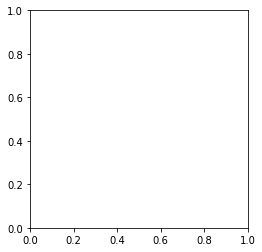

In [147]:
%matplotlib inline
plt.imshow(np.reshape(data_in[0], (16, 1000, -1)))
plt.show()

## Test on single frame

In [4]:
points = frames[0]
x = points[:,0]
y = points[:,1]
z = points[:,2]
w = np.arctan2(y, x)
r = np.sqrt(x*x+y*y)
j = np.arange(x.size)

<IPython.core.display.Javascript object>


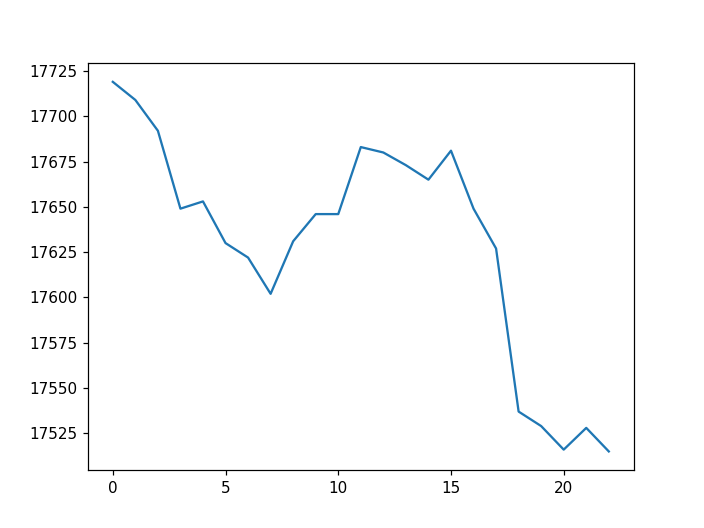

In [5]:
plt.figure()
plt.plot([len(frame) for frame in frames])

<IPython.core.display.Javascript object>


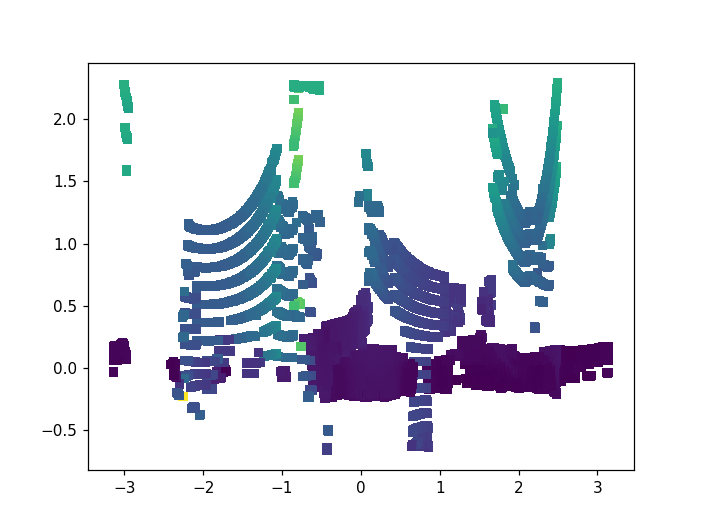

In [6]:
plt.figure()
plt.scatter(w, z, c=r, marker='s', edgecolor="none")

<IPython.core.display.Javascript object>


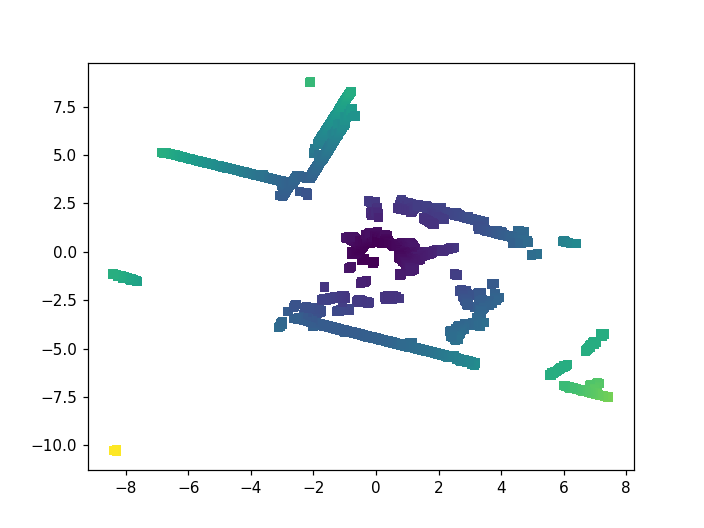

In [8]:
plt.figure()
plt.scatter(x,y, c=r, marker='s', edgecolor="none")

<IPython.core.display.Javascript object>


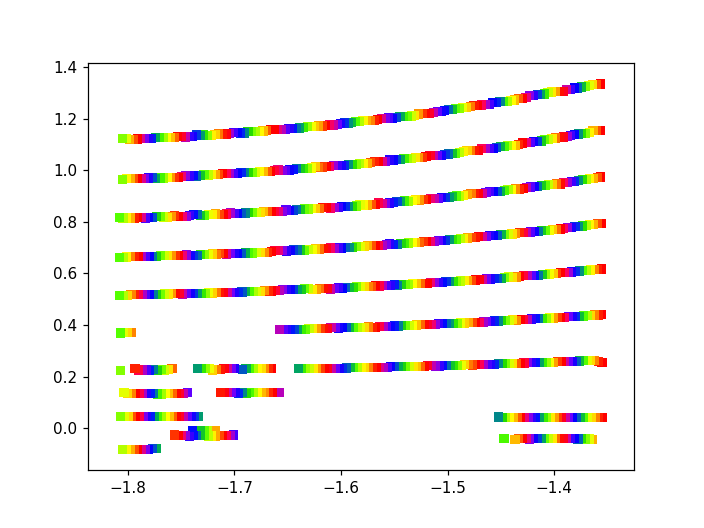

In [9]:
plt.figure()
plt.scatter(w[:1000],z[:1000], c=j[:1000], marker='s', edgecolor="none", cmap='prism')

In [ ]:
val = gridify(w,z,r, resolution=(200,100), value_approximation='min')[1]

In [ ]:
plt.figure()
plt.imshow(val)

## Animation

<IPython.core.display.Javascript object>


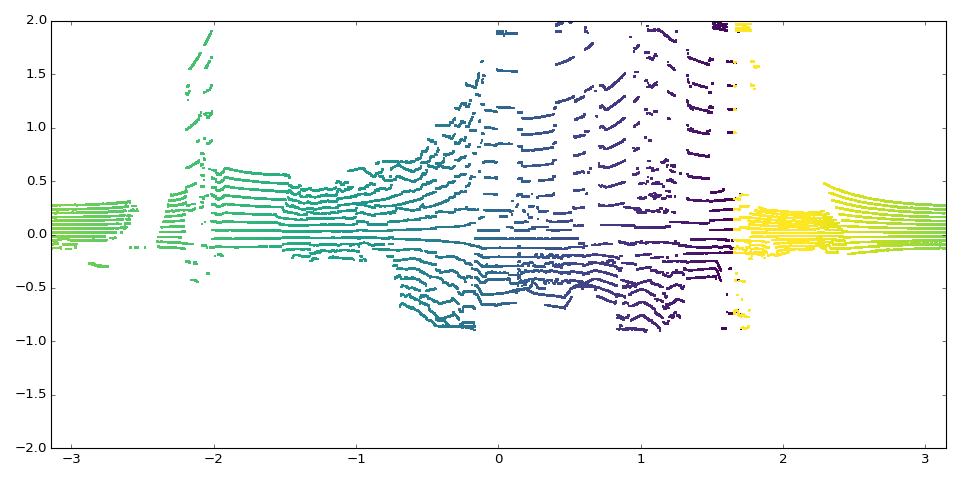

In [12]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
FPS = 30
fig = plt.figure("Generating Animation", figsize=(12,6))
norm = plt.Normalize()
ax = plt.axes()
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-2,2)
plt.tight_layout()
scat = ax.scatter([], [], c=[], marker='s', edgecolor="none", s=5)
def update(frame_number):
    points = frames[frame_number % len(frames)]
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    w = np.arctan2(y, x)
    r = np.sqrt(x*x+y*y)
    j = np.arange(x.size)
    scat.set_offsets(np.array([w,z]).T)
    scat.set_facecolor(plt.cm.viridis(norm(j)))
try:
  anim = FuncAnimation(fig, update, frames=len(frames), interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

In [ ]:
rc('animation', html='html5')
anim

In [ ]:
anim.save('/tmp/LIDAR.mp4', fps=FPS, extra_args=['-vcodec', 'libx264'])

<IPython.core.display.Javascript object>


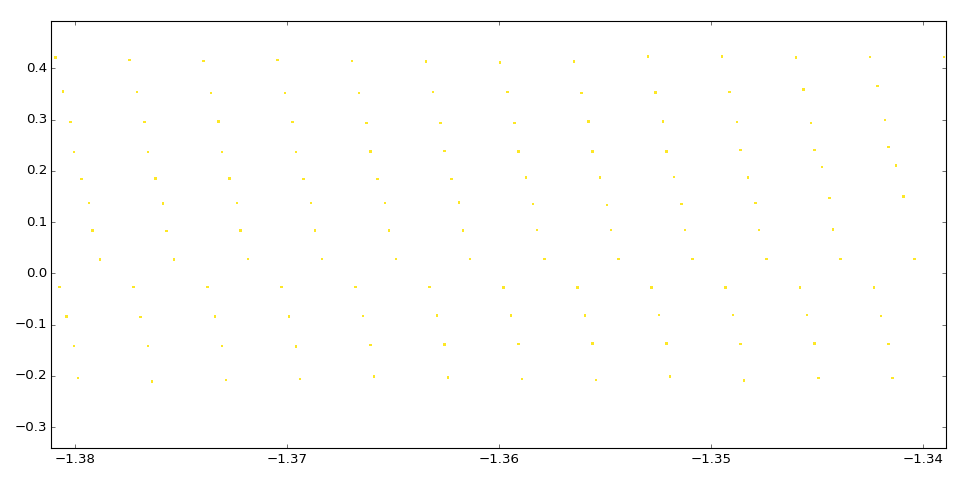

In [9]:
# Animating point order
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
FPS = 60
MULT = 20
fig3 = plt.figure("Generating Animation 2", figsize=(12,6))
norm = plt.Normalize()
ax3 = plt.axes()
ax3.set_xlim(-np.pi,np.pi)
ax3.set_ylim(-2,2)
plt.tight_layout()
points = frames[0]
x = points[:,0]
y = points[:,1]
z = points[:,2]
w = np.arctan2(y, x)
r = np.sqrt(x*x+y*y)
j = np.arange(x.size)
scat3 = ax3.scatter([], [], c=[], marker='s', edgecolor="none", s=5, vmin=min(r), vmax=max(r))
def update3(frame_number):
    i = frame_number*MULT
    scat3.set_offsets(np.array([w[:i],z[:i]]).T)
    scat3.set_facecolor(plt.cm.viridis(r[:i]))
try:
  anim3 = FuncAnimation(fig3, update3, frames=len(j)/MULT, interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

## Animation Gridified

In [ ]:
grids = []
for points in frames:
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    w = np.arctan2(y, x)
    r = np.sqrt(x*x+y*y)
    grids.append(gridify(w,z,r, resolution=(200,100), value_approximation='min')[1])

In [ ]:
from matplotlib import rc
from matplotlib.animation import FuncAnimation
#
FPS = 30
fig2 = plt.figure("PColorMesh Animation", figsize=(12,6))
ax2 = plt.axes()
plt.tight_layout()
im = ax2.imshow(grids[0])
def update2(frame_number):
    im.set_data(grids[frame_number % len(frames)])
    im.set_cmap(plt.get_cmap("viridis"))
try:
  anim2 = FuncAnimation(fig2, update2, frames=len(frames), interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

In [ ]:
anim2.save('/tmp/LIDAR_grid.mp4', fps=FPS, extra_args=['-vcodec', 'libx264'])